In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
from module import Model_Training
import logging
tf.get_logger().setLevel(logging.ERROR)


2023-04-06 17:24:19.375528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 17:24:19.487026: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-06 17:24:19.893909: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/C

In [2]:
# full_img_path = '/mnt/d/Datasets/CBIS_DDSM/full/'
roi_img_path = '/mnt/d/CBIS-DDSM/new_ROI/ROI_CLAHE_train_val_split/'
img_height = 224
img_width = 224
batch_size = 4
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
misclassified_store = '/mnt/c/Users/user/Desktop/CBIS_DDSM_misclassified/'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  # validation_split=0.2,
  # subset='training',
  seed=48,
  batch_size=None)
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  # validation_split=0.2,
  # subset='validation',
  seed=48,
  batch_size=None)
#train_ds = train_ds.concatenate(val_ds)
train=train_ds.batch(batch_size)
val = val_ds.batch(batch_size)
train = train.prefetch(AUTOTUNE)
val = val.prefetch(AUTOTUNE)
#val = None
# train_ds = train_ds.concatenate(val_ds)
# train = train_ds.batch(batch_size)
# train = train.prefetch(AUTOTUNE)

Found 1719 files belonging to 2 classes.
Found 363 files belonging to 2 classes.


In [4]:
test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  # validation_split=0.5,
  # subset='training',
  image_size=(img_height, img_width),
  seed = 48,
  shuffle=None,
  batch_size=batch_size)
# val_ds = tf.keras.utils.image_dataset_from_directory(
  # roi_img_path+'test/',
  # label_mode="categorical",
  # validation_split=0.5,
  # subset='validation',
  # image_size=(img_height, img_width),
  # seed = 42,
  # batch_size=batch_size)
# val = val_ds.prefetch(AUTOTUNE)
# train_test = tf.keras.utils.image_dataset_from_directory(
  # roi_img_path+'train/',
  # label_mode="categorical",
  # image_size=(img_height, img_width),
  # shuffle=False,
  # batch_size=batch_size)
# val_test = tf.keras.utils.image_dataset_from_directory(
  # roi_img_path+'val/',
  # label_mode="categorical",
  # image_size=(img_height, img_width),
  # shuffle=False,
  # batch_size=batch_size)
# val = test.prefetch(AUTOTUNE)

Found 308 files belonging to 2 classes.


In [5]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            f' Epoch {epoch+1}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            # f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')
Model_Training = Model_Training()

# Inception V3

In [6]:
train_log = '/home/jj/FYP/log/InceptionV3_CBIS_DDSM/'
weights = '/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/'

## Warm up

In [7]:
tf.keras.backend.clear_session()
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=5,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'WarmUP/best_model',
    learning_rate=5e-4,init_lr=1e-5,
    warmup=4,cosine=0,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
# model.save_weights(weights+'Dense/best_model')

2023-04-06 17:24:45.167167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 505 of 1024
2023-04-06 17:24:55.097550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1017 of 1024
2023-04-06 17:24:55.112999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-04-06 17:24:56.028482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-06 17:25:13.330474: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GP

430/430 [==============================] - ETA: 0s - loss: 92.6552 - categorical_accuracy: 0.5300 - recall: 0.4263 - recall_1: 0.6263

KeyboardInterrupt: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['sequential[0][0]']             
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']    

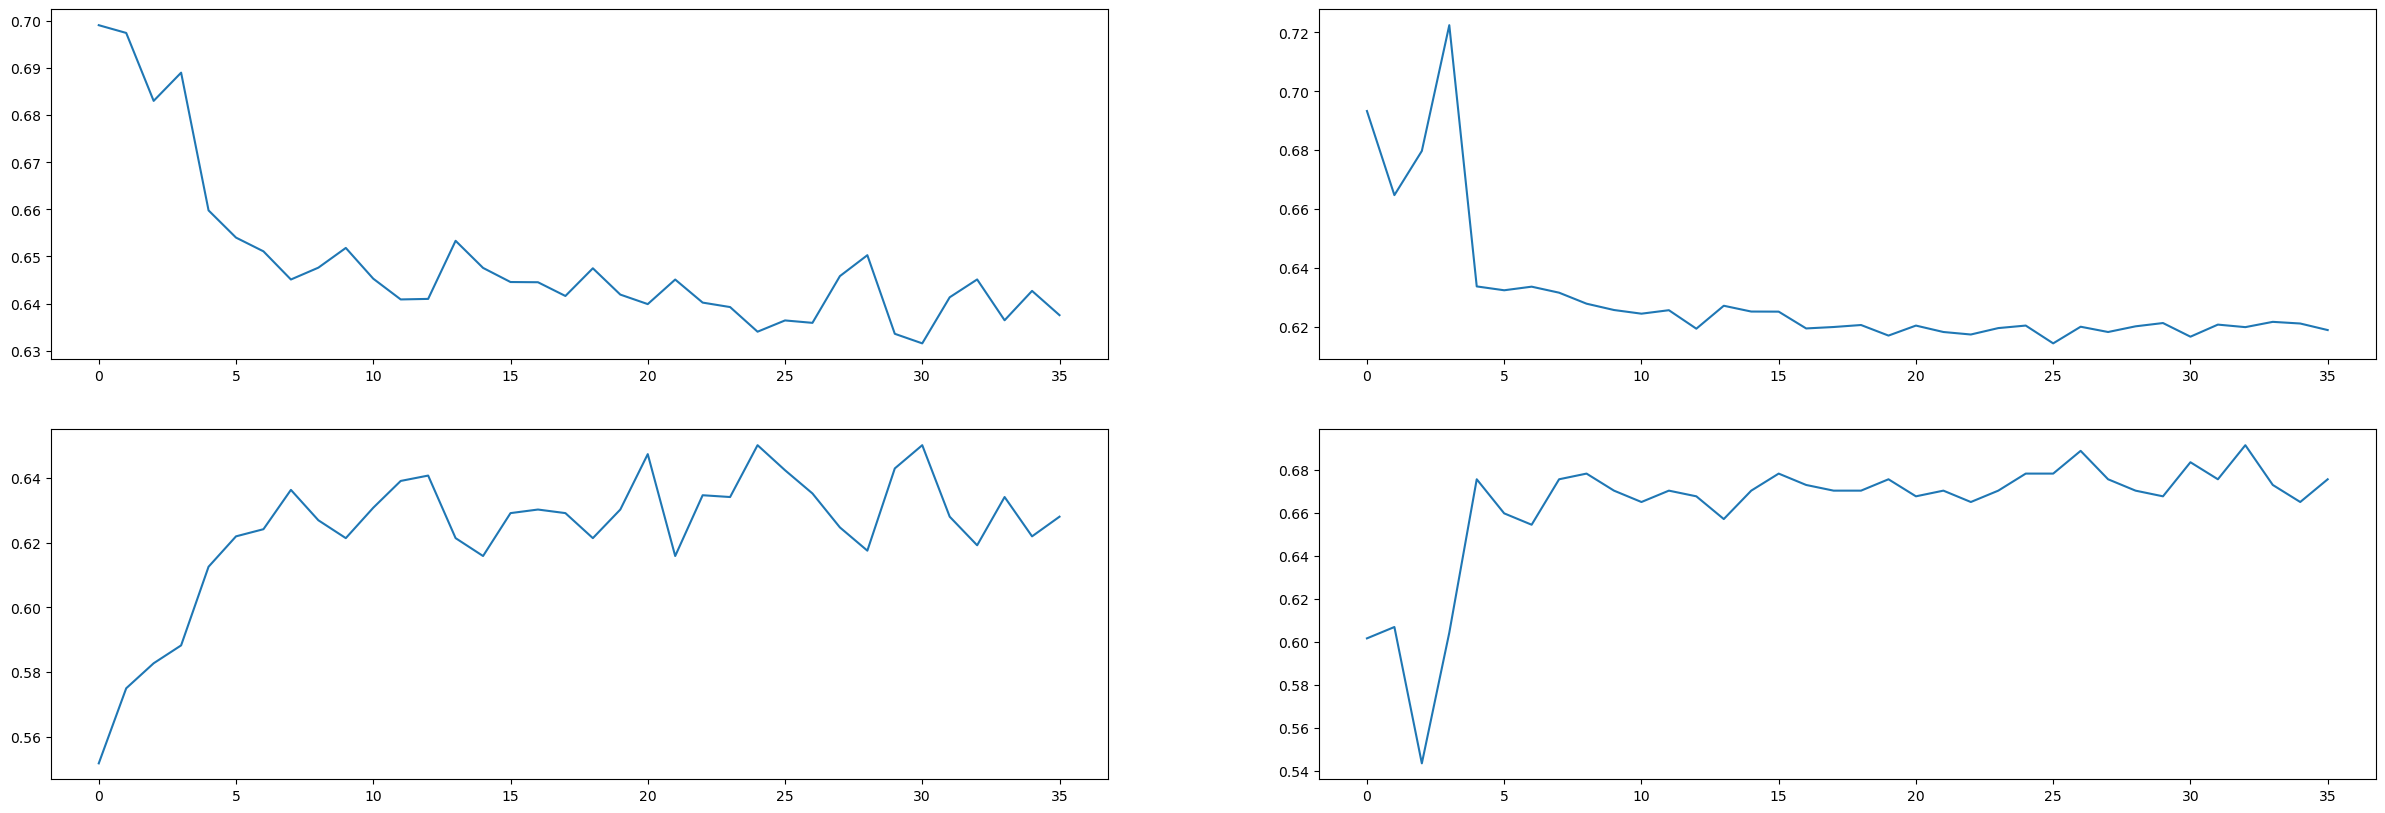

In [ ]:
tf.keras.backend.clear_session()
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'dense.csv',
    load_weights = weights+'WarmUP/best_model',
    save_weights = weights+'Dense/best_model',
    learning_rate=5e-4,init_lr=1e-5,
    warmup=0,cosine=50,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
# model.save_weights(weights+'Dense/best_model')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 inception_v3 (Functional)      (None, 5, 5, 2048)   21802784    ['tf.math.subtract[0][0]']   

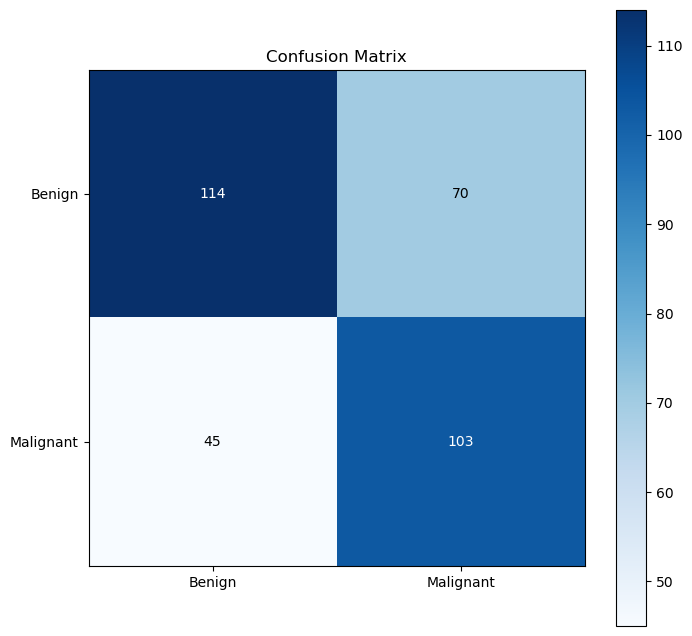

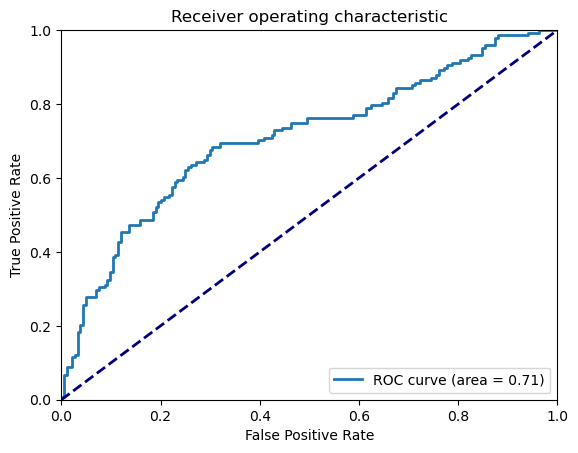

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('inceptionv3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Dense/best_model',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

39/39 [==============================] - 8s 130ms/step - loss: 0.5925 - categorical_accuracy: 0.6948 - precision: 0.6466 - recall: 0.6466 - auc: 0.7571

## Fine Tune

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['sequential[0][0]']             
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']    

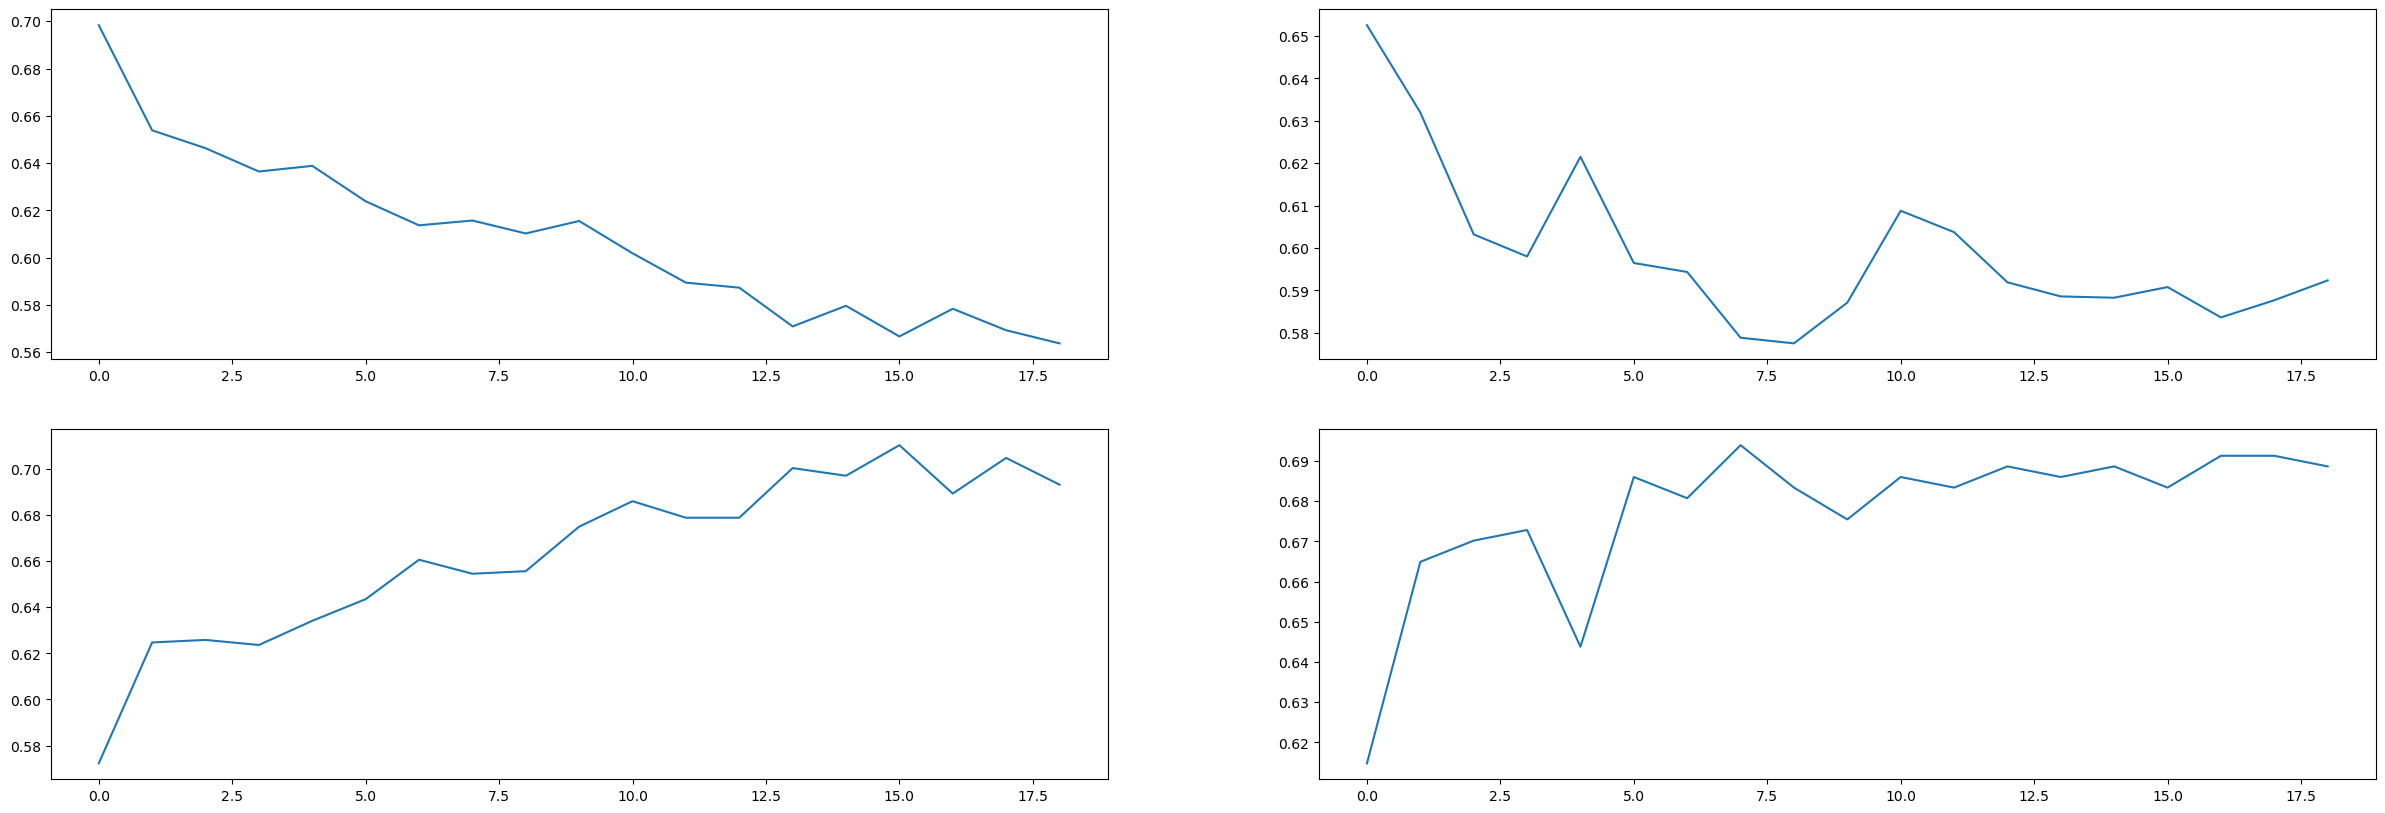

In [ ]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=5e-5,init_lr=1e-5,warmup=0,cosine=50,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

## Test

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 inception_v3 (Functional)      (None, 5, 5, 2048)   21802784    ['tf.math.subtract[0][0]']   

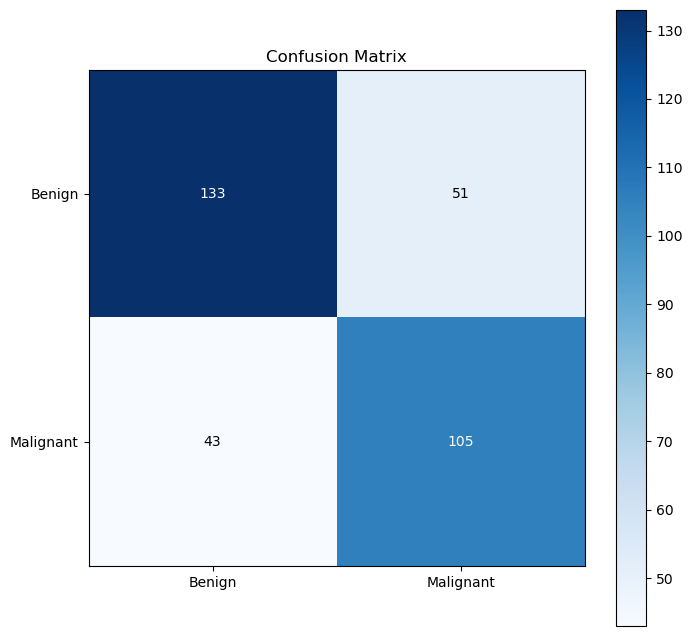

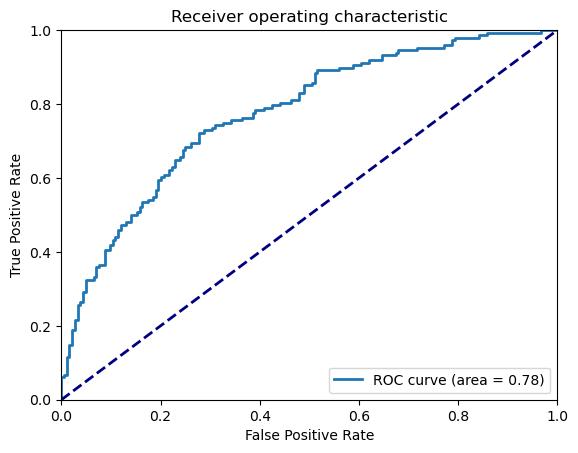

In [ ]:
tf.keras.backend.clear_session()
# model.evaluate(test)
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('inceptionv3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final/Final',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

10 [==============================] - 2s 63ms/step - loss: 0.5722 - categorical_accuracy: 0.7138 - precision: 0.6507 - recall: 0.7143 - auc: 0.7968

Image without padding, normalisation used

21/21 [==============================] - 2s 40ms/step - loss: 0.8528 - categorical_accuracy: 0.7019 - precision_2: 0.7778 - precision_3: 0.6331


## FT 2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['sequential[0][0]']             
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']    

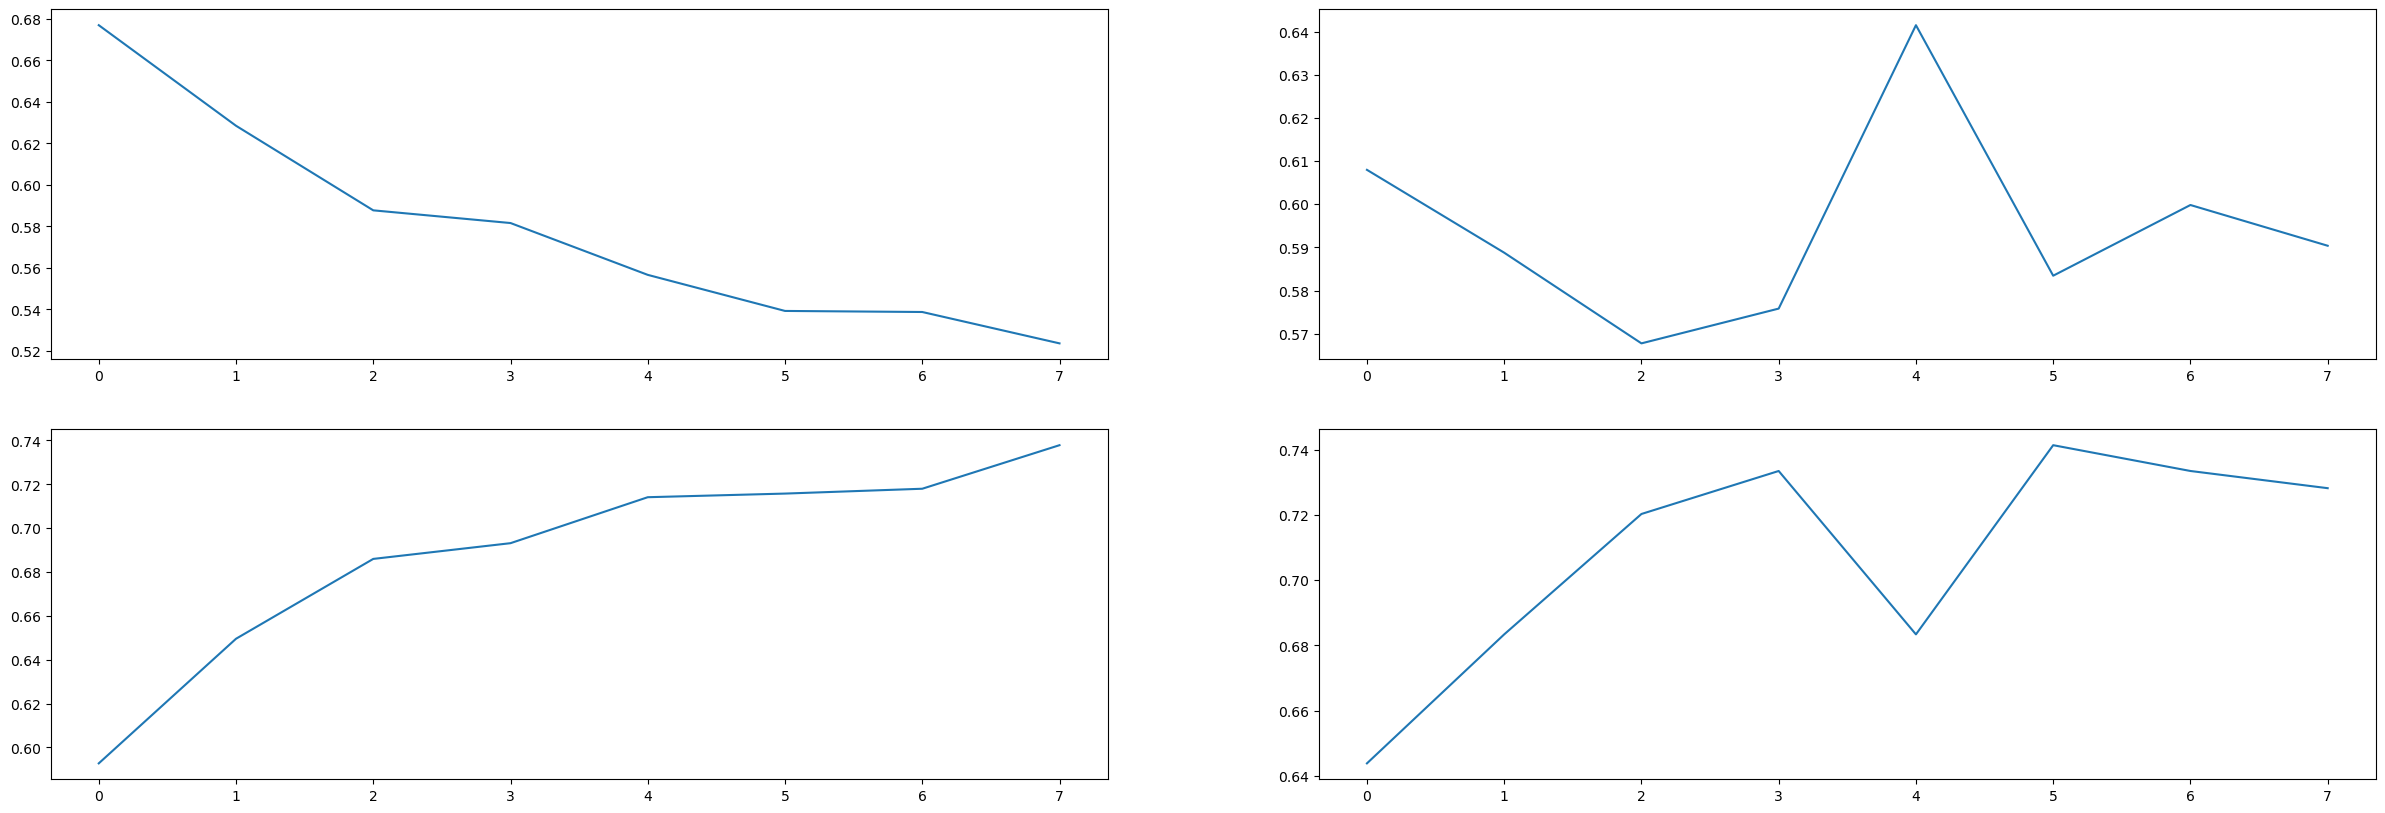

In [ ]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop=5,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = -1,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'Fine_Tune_2.csv',
    load_weights = weights+'Final/Final',
    save_weights = weights+'Fine_Tune_2/best_model',
    learning_rate=5e-6,init_lr=1e-7,warmup=0,cosine=40,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final_2/Final_2')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 inception_v3 (Functional)      (None, 5, 5, 2048)   21802784    ['tf.math.subtract[0][0]']   

2023-03-30 15:52:18.889731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-30 15:52:23.063043: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


 5/83 [>.............................] - ETA: 2s - loss: 0.3742 - categorical_accuracy: 0.9000 - precision: 0.0000e+00 - recall: 0.9000 - auc: 0.9400 

2023-03-30 15:52:23.738136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


83/83 [==============================] - 3s 18ms/step


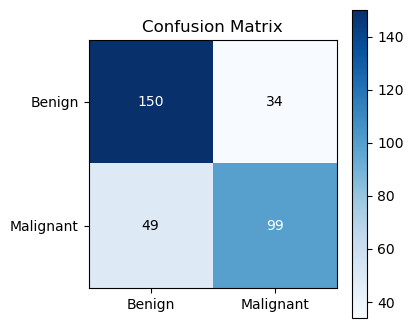

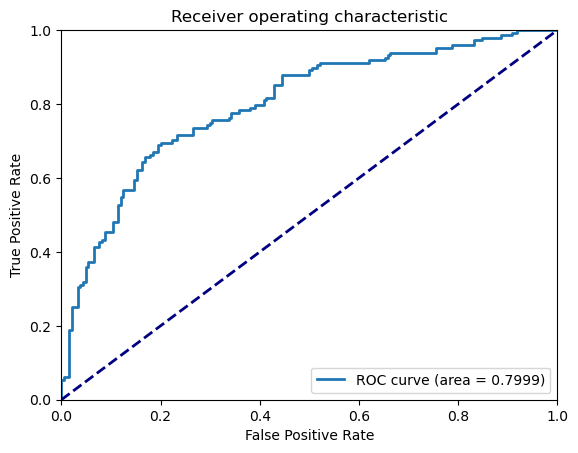

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=0),
          tf.keras.metrics.AUC()]

# model = Model_Training.build_model('inceptionv3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Fine_Tune_2/best_model',metrics=metric)
model = Model_Training.build_model('inceptionv3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,
                                   img_height=img_height,img_width=img_width,training=False)
# model.load_weights(weights+'/Fine_Tune/best_model')
model.evaluate(test)

prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

In [ ]:
# InceptionV3_misclassified = Model_Training.store_misclassified(model,test,'/mnt/c/Users/user/Desktop/CBISDDSM_misclassified_Images/InceptionV3')

WITHOUT ANYTHING 39/39 [==============================] - 7s 131ms/step - loss: 0.6108 - categorical_accuracy: 0.7078 - precision: 0.6287 - recall: 0.7895 - auc: 0.7788

WITHOUT ARTIFACT 39/39 [==============================] - 2s 15ms/step - loss: 0.6176 - categorical_accuracy: 0.6916 - precision: 0.6118 - recall: 0.7820 - auc: 0.7767

MEDIAN 39/39 [==============================] - 2s 28ms/step - loss: 0.5914 - categorical_accuracy: 0.7273 - precision: 0.6738 - recall: 0.7143 - auc: 0.7855

GCN /39 [==============================] - 2s 15ms/step - loss: 0.6231 - categorical_accuracy: 0.7078 - precision: 0.6463 - recall: 0.7143 - auc: 0.7704

CLAHE 39/39 [==============================] - 10s 214ms/step - loss: 0.5899 - categorical_accuracy: 0.7370 - precision: 0.6688 - recall: 0.7744 - auc: 0.7917

1024 39/39 [==============================] - 10s 203ms/step - loss: 0.5663 - categorical_accuracy: 0.7338 - precision: 0.6735 - recall: 0.7444 - auc: 0.8124

Flatten 1024 39/39 [==============================] - 2s 28ms/step - loss: 0.5756 - categorical_accuracy: 0.7155 - precision: 0.6786 - recall: 0.7143 - auc: 0.8121

dense 8 with 2 regularise 39/39 [==============================] - 2s 26ms/step - loss: 0.6102 - categorical_accuracy: 0.6818 - precision: 0.3000 - recall: 0.7895 - auc: 0.7378

GAP,1024all,ADAM all,seed=48 39/39 [==============================] - 2s 28ms/step - loss: 0.3025 - categorical_accuracy: 0.7565 - precision: 0.7231 - recall: 0.7068 - auc: 0.8207

All Train set 39/39 [==============================] - 2s 25ms/step - loss: 0.5569 - categorical_accuracy: 0.7615 - precision: 0.7419 - recall: 0.6917 - auc: 0.8273

ALL train flatten 39/39 [==============================] - 2s 25ms/step - loss: 0.8193 - categorical_accuracy: 0.7500 - precision: 0.7295 - recall: 0.8114 - auc: 0.8021


# Resnet50

## Initialising

In [ ]:
weights = '/home/jj/FYP/Checkpoint/Resnet50_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Resnet50_CBIS_DDSM/'

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['sequential[0][0]']             
 ingOpLambda)                                                                                     
                                                                                              

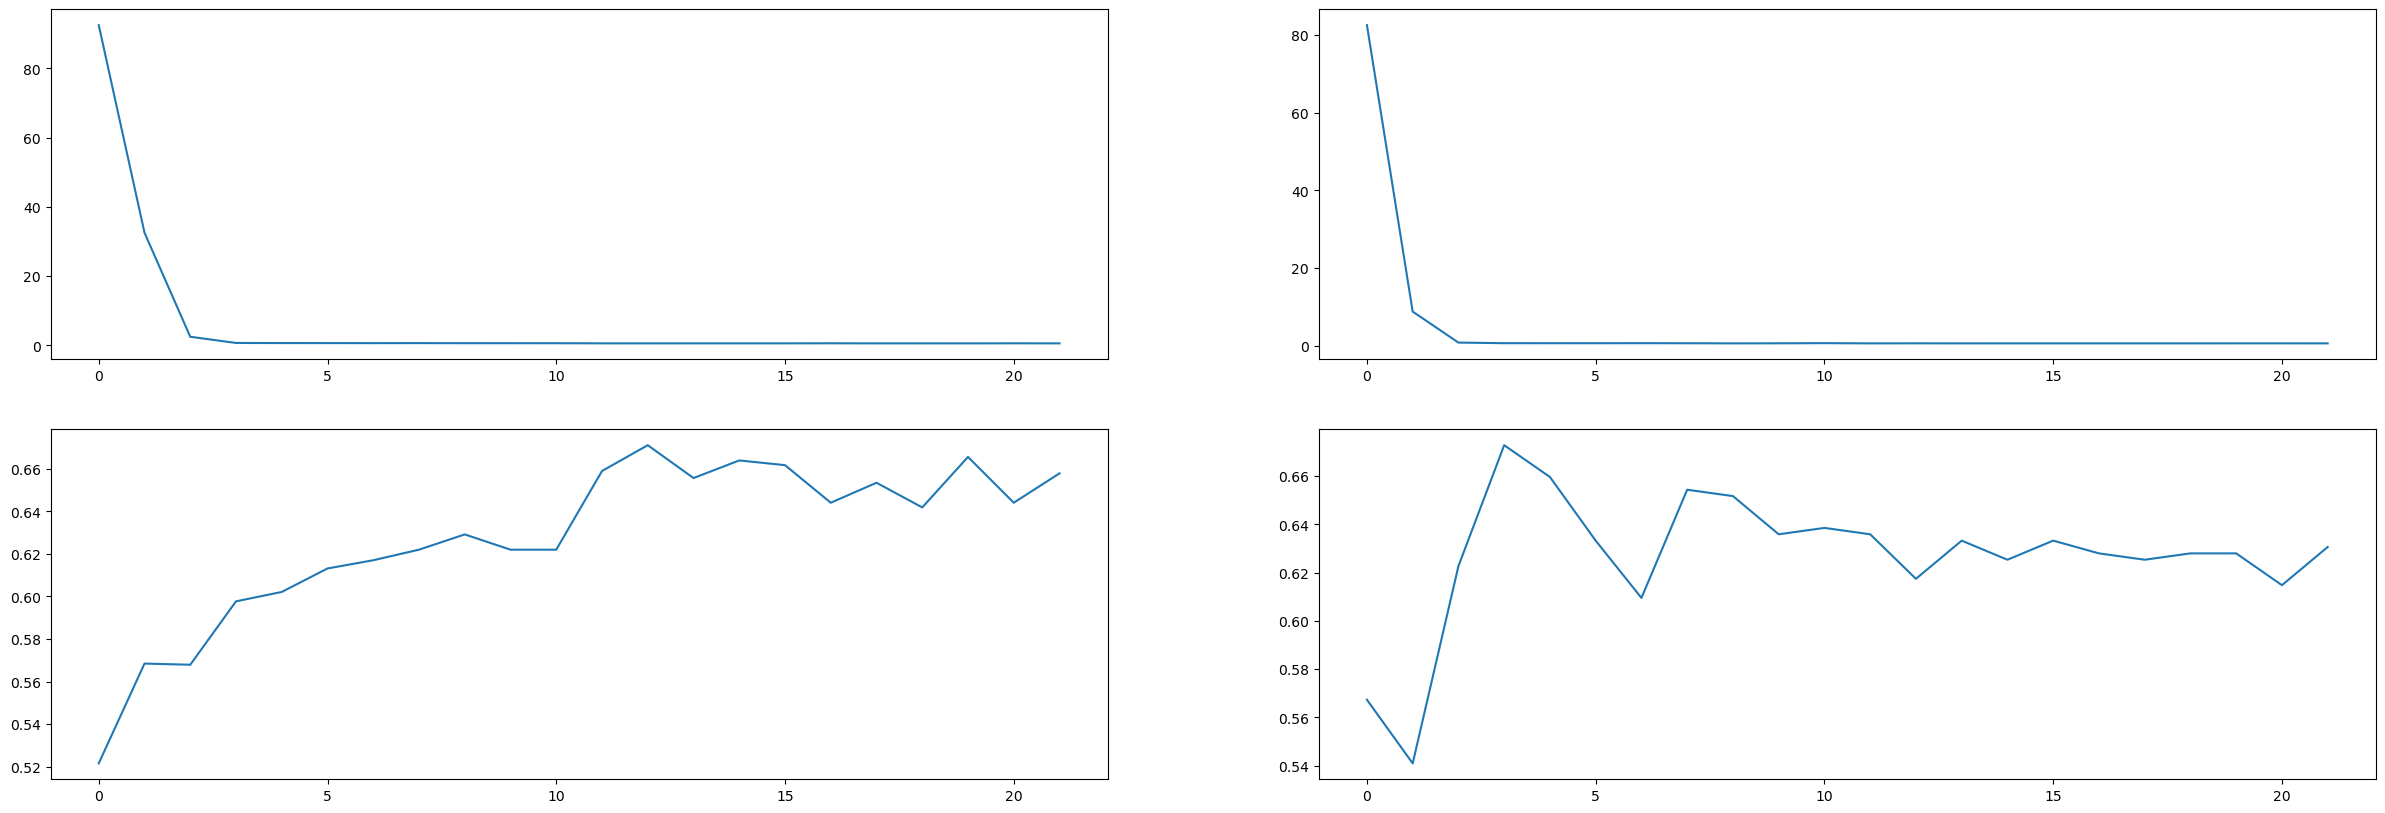

In [ ]:
tf.keras.backend.clear_session()
model, resnet_dense_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    trainable_layers = False,flatten='global_average_pooling',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=5e-4,init_lr=1e-5,warmup=5,cosine=50,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['sequential[0][0]']             
 ingOpLambda)                                                                                     
                                                                                              

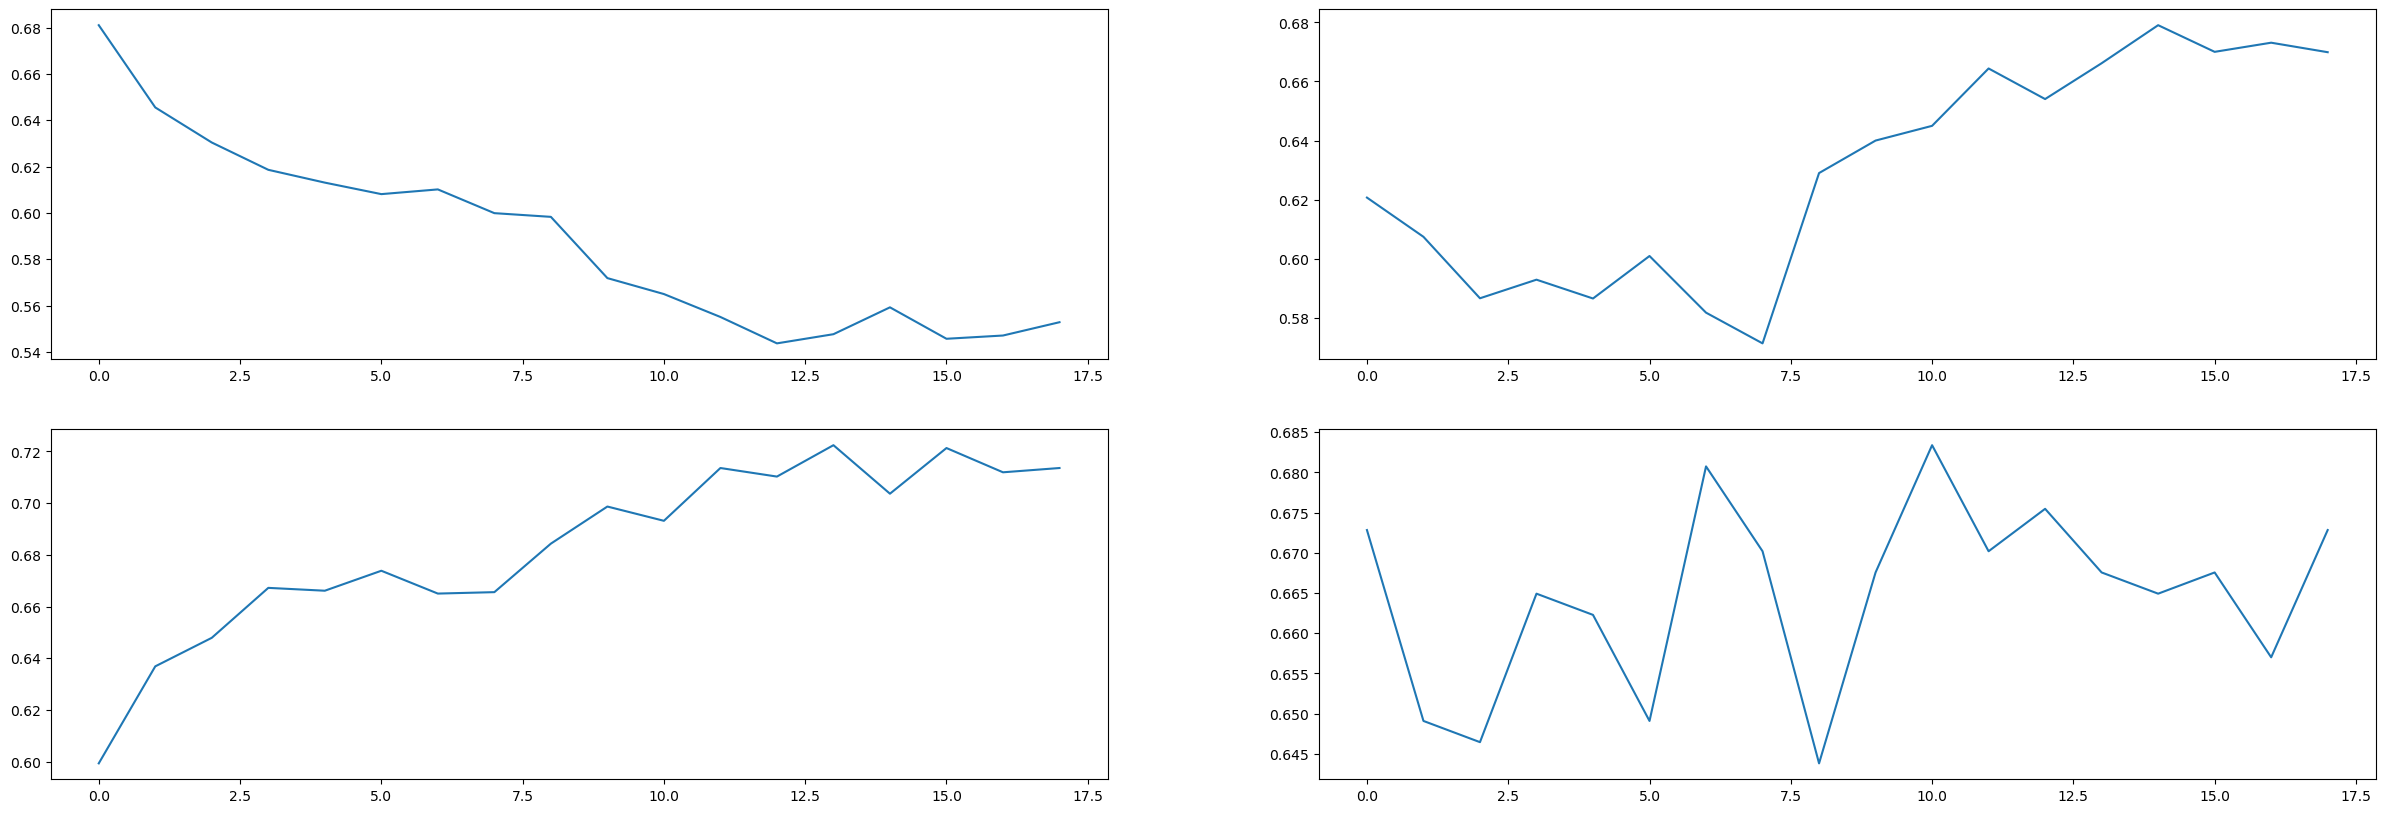

In [ ]:
tf.keras.backend.clear_session()
model, resnet_fine_tune_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    trainable_layers = 22,flatten='global_average_pooling',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=5e-5,init_lr=1e-5,warmup=0,cosine=50,min_lr=1e-7,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

## Test

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_2[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                            

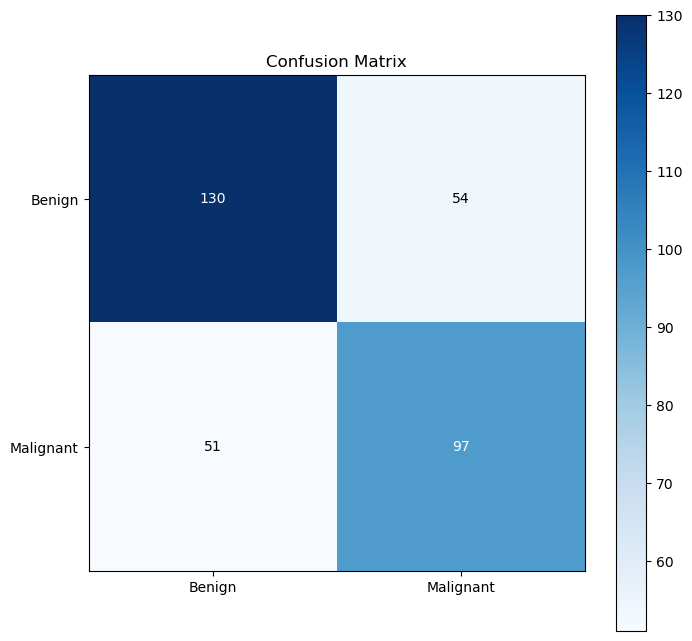

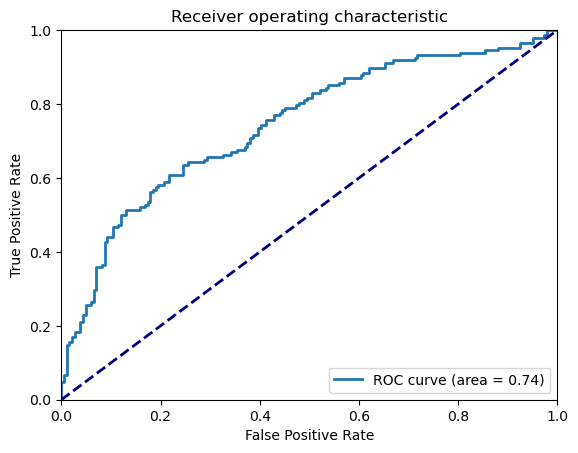

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('resnet50',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final/Final',metrics=metric,img_height=img_height,img_width=img_width)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

## FT2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['sequential[0][0]']             
 ingOpLambda)                                                                                     
                                                                                              

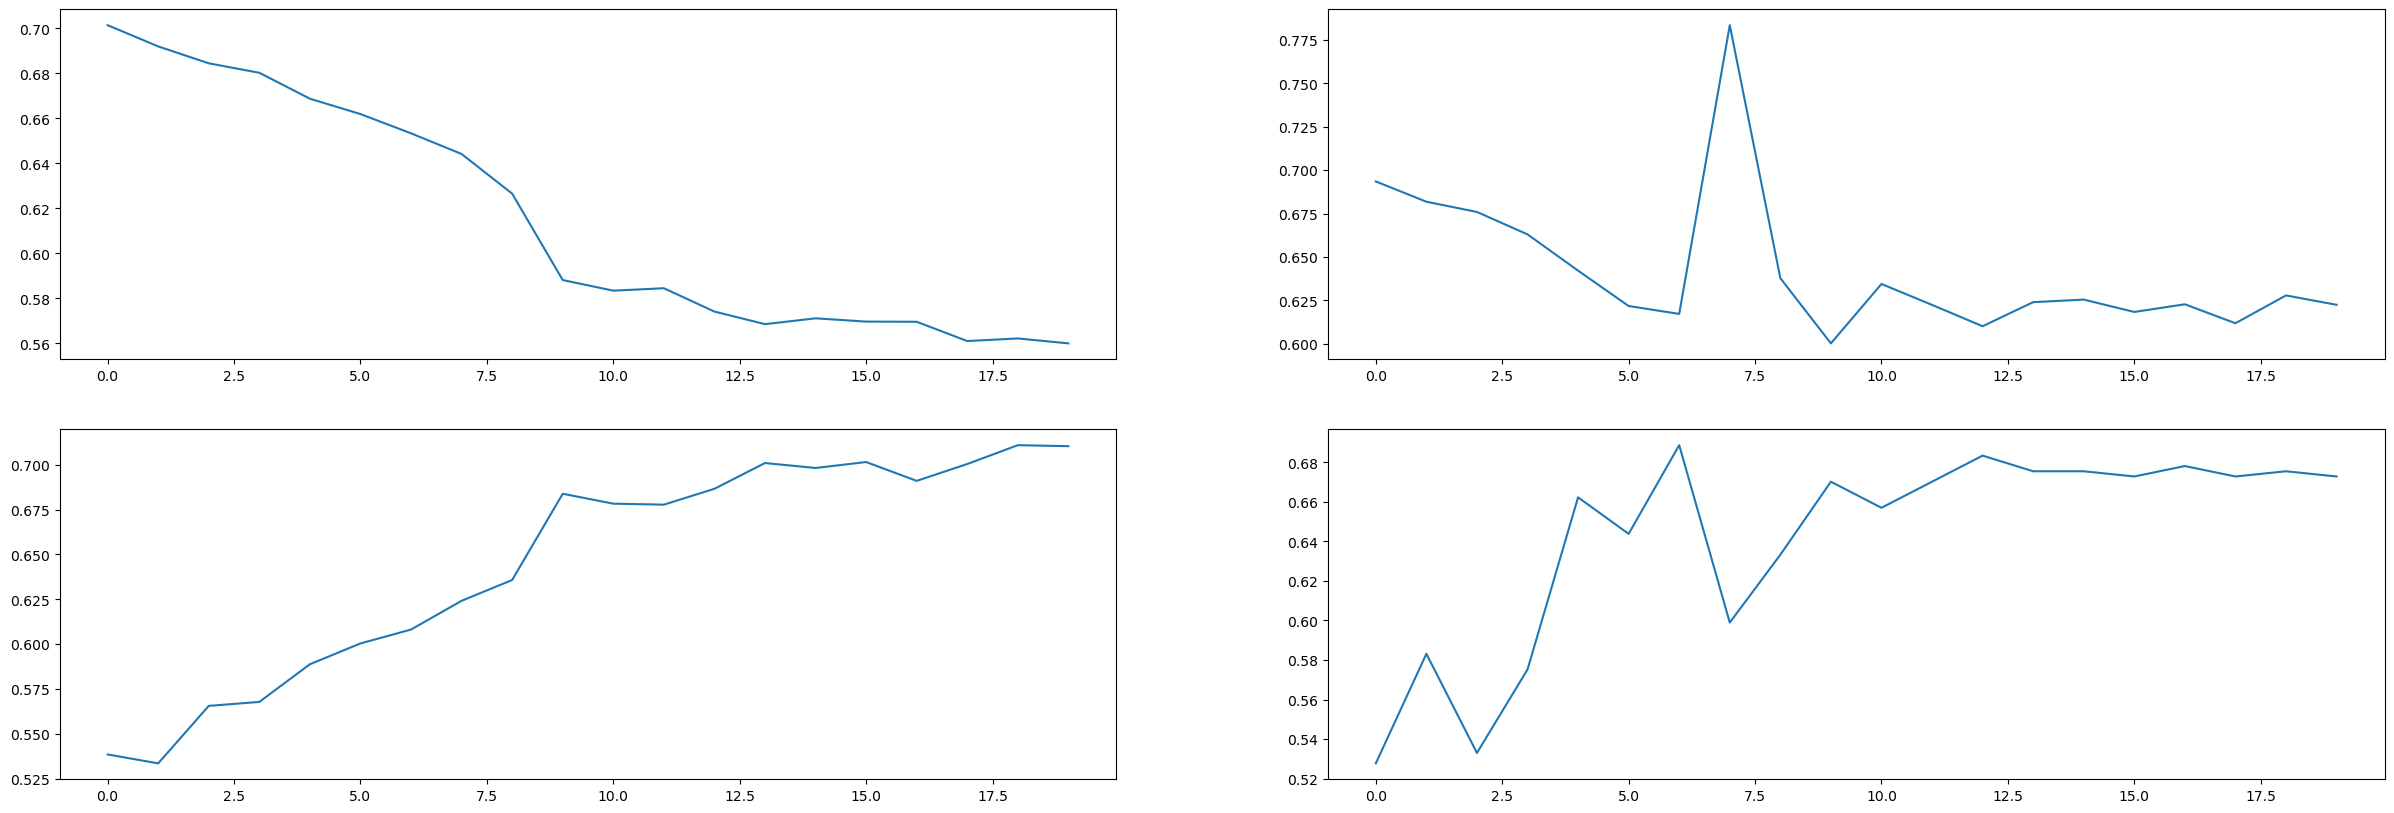

In [ ]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = -1,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'Fine_Tune_2.csv',
    load_weights = weights+'Final/Final',
    save_weights = weights+'Fine_Tune_2/best_model',
    learning_rate=1e-5,init_lr=1e-7,warmup=0,cosine=15,min_lr=1e-8,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final_2/Final_2')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_2[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                            

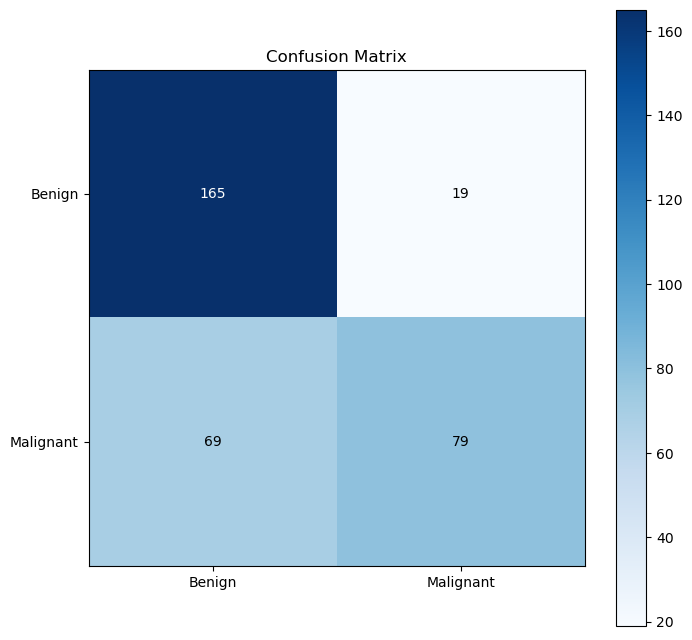

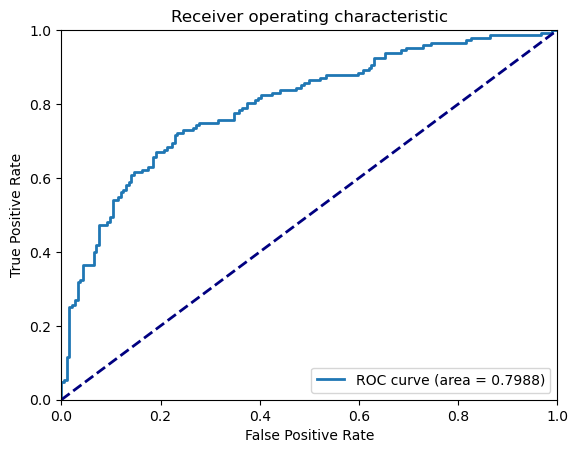

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('resnet50',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

In [ ]:
# store_misclassified = misclassified_store+'resnet50/'
# model.evaluate(test)
# misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
# misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
# misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

20/20 [==============================] - 1s 57ms/step - loss: 0.3054 - categorical_accuracy: 0.6656 - precision: 0.6656 - recall: 0.6656 - auc: 0.7364

# VGG16

In [ ]:
weights = '/home/jj/FYP/Checkpoint/Vgg16_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Vgg16_CBIS_DDSM/'

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['sequential[0][0]']             
 ingOpLambda)                                                                                     
                                                                                              

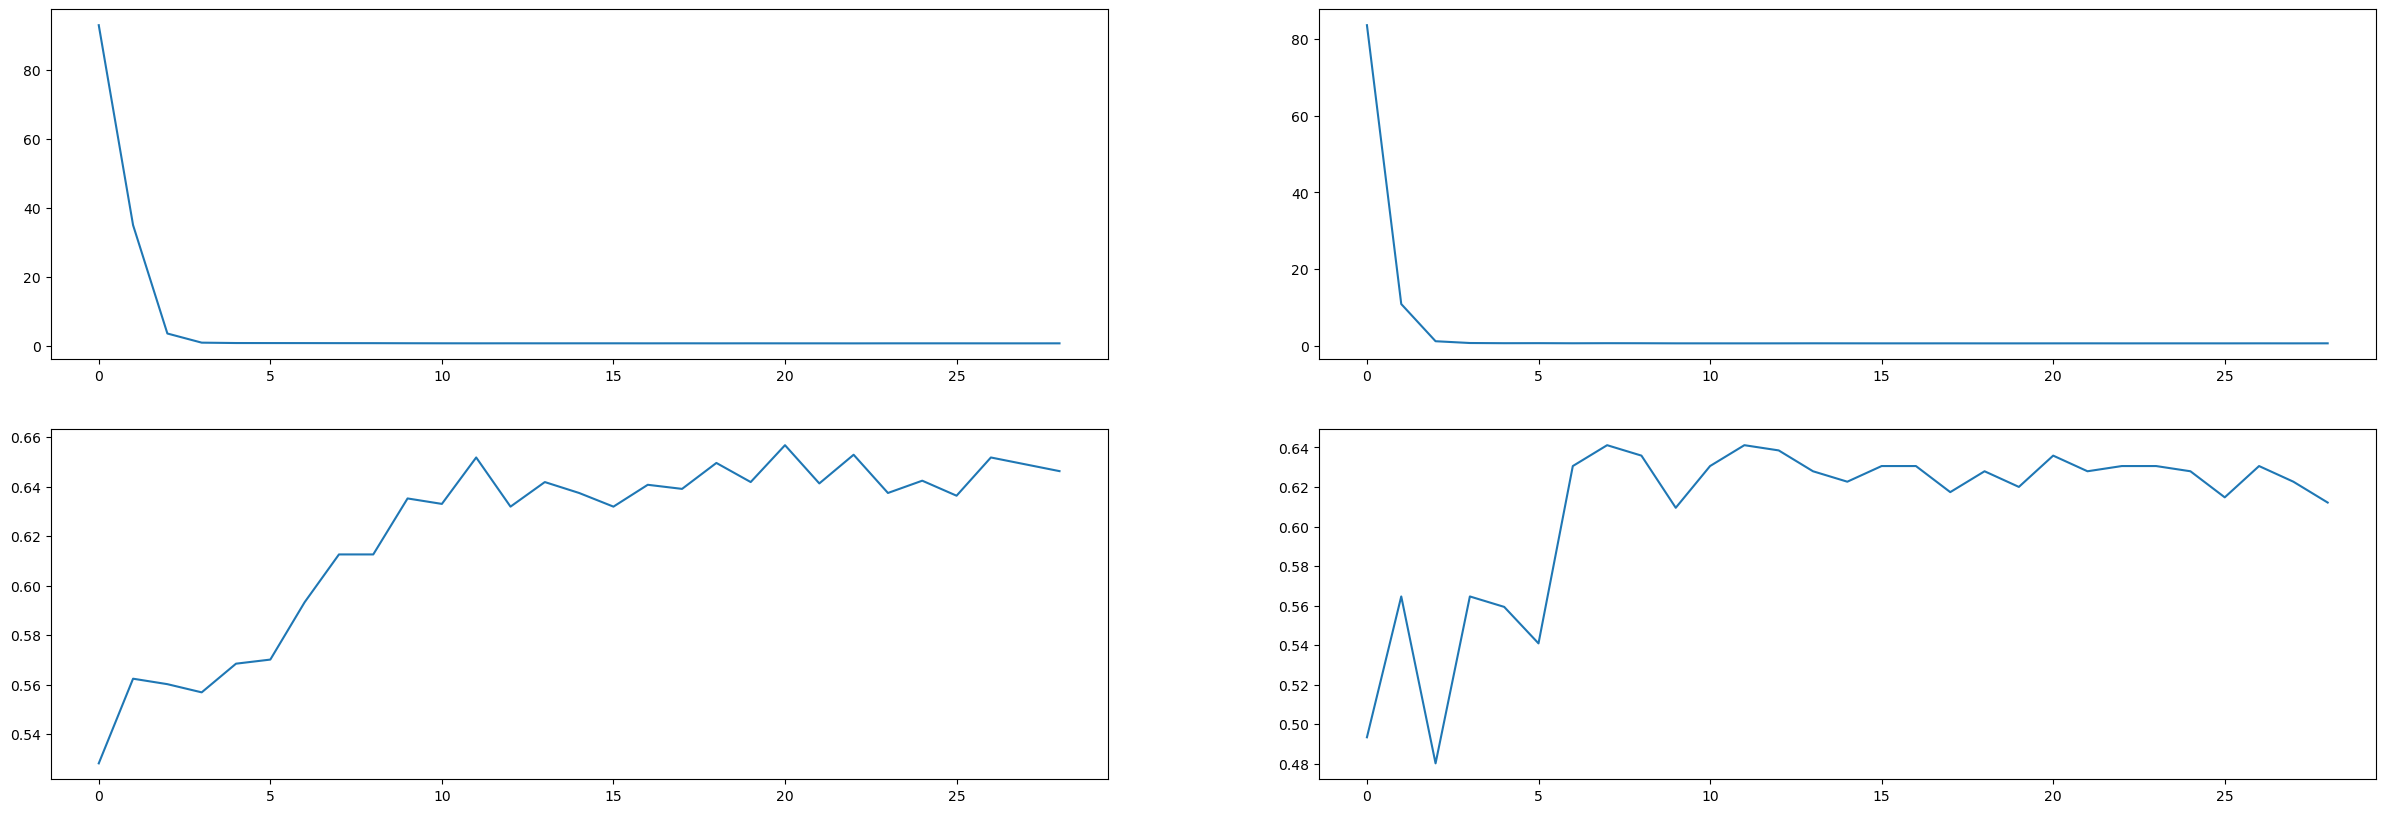

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Vgg16_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Vgg16_CBIS_DDSM/'
model, vgg16_dense_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    trainable_layers = False,flatten='global_average_pooling',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=5e-4,init_lr=1e-5,warmup=5,cosine=50,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['sequential[0][0]']             
 ingOpLambda)                                                                                     
                                                                                              

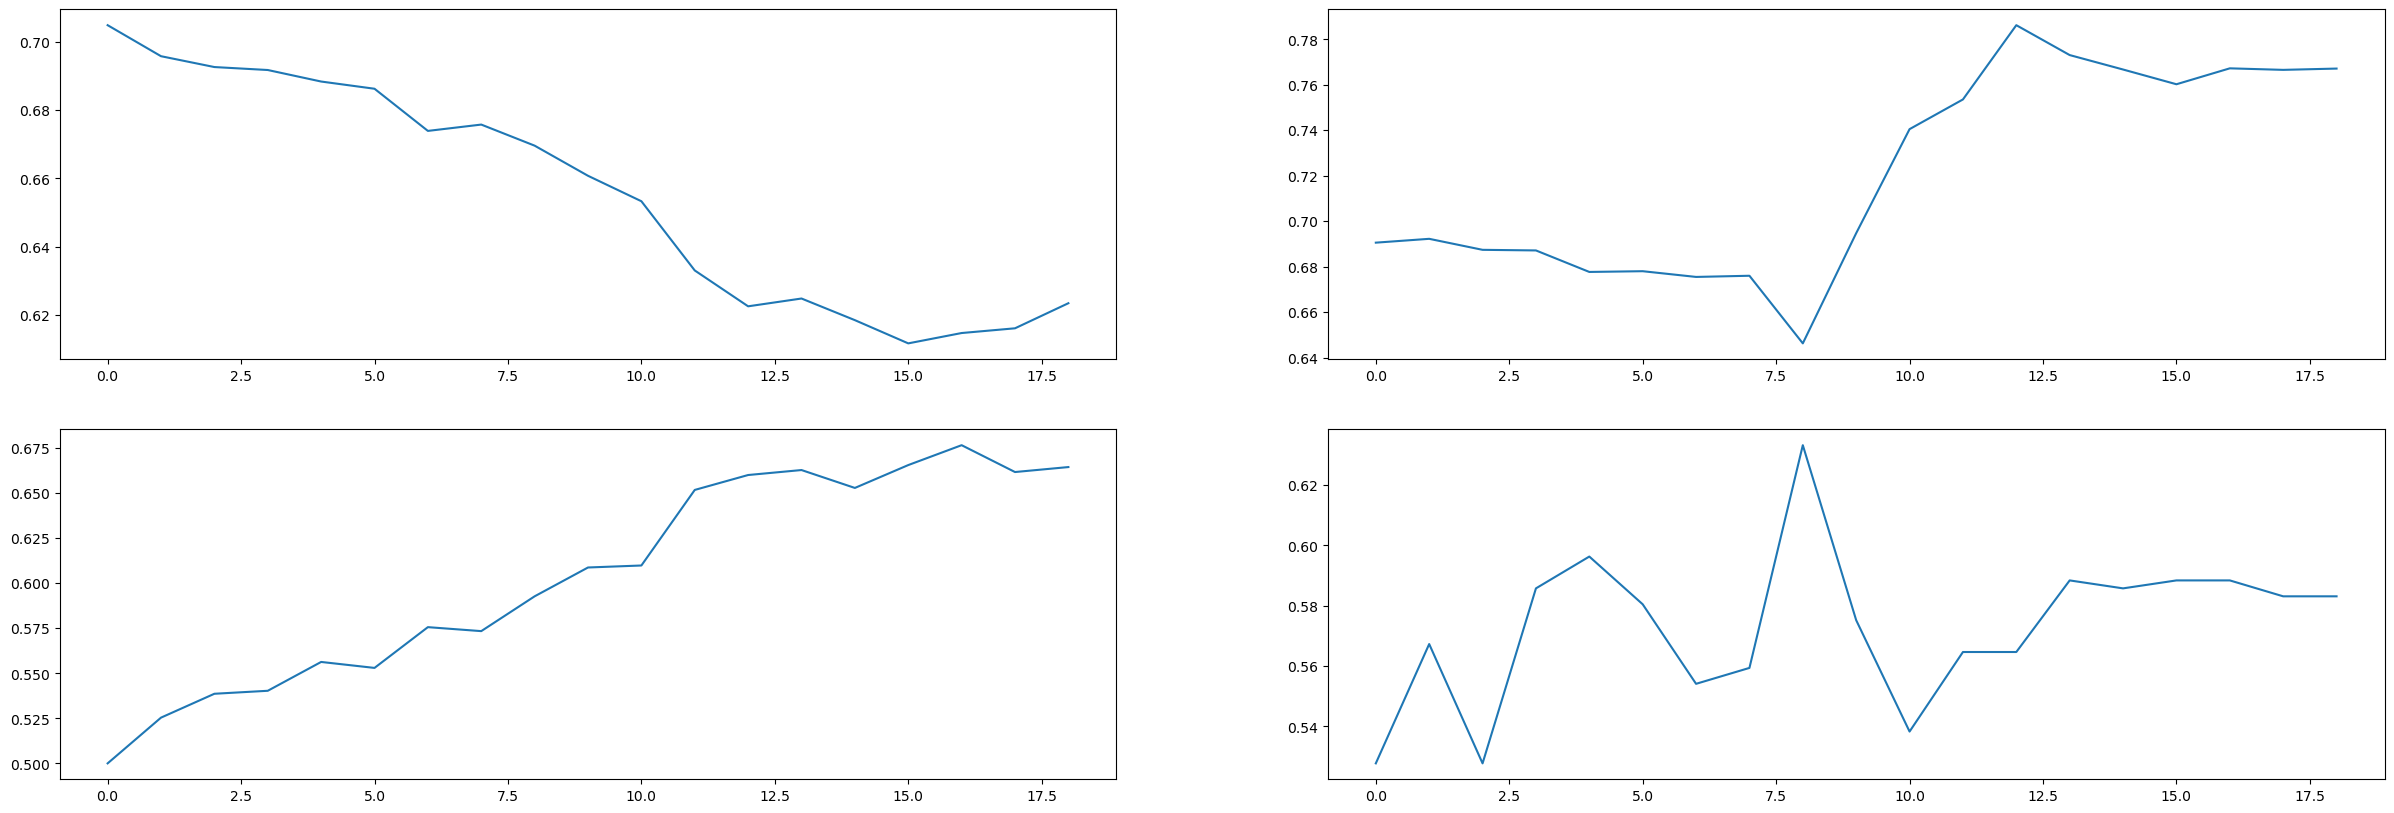

In [ ]:
tf.keras.backend.clear_session()
model, vgg16_fine_tune_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    trainable_layers = 8,flatten='global_average_pooling',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-5,init_lr=1e-5,warmup=0,cosine=50,min_lr=1e-7,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

## Test

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_2[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                            

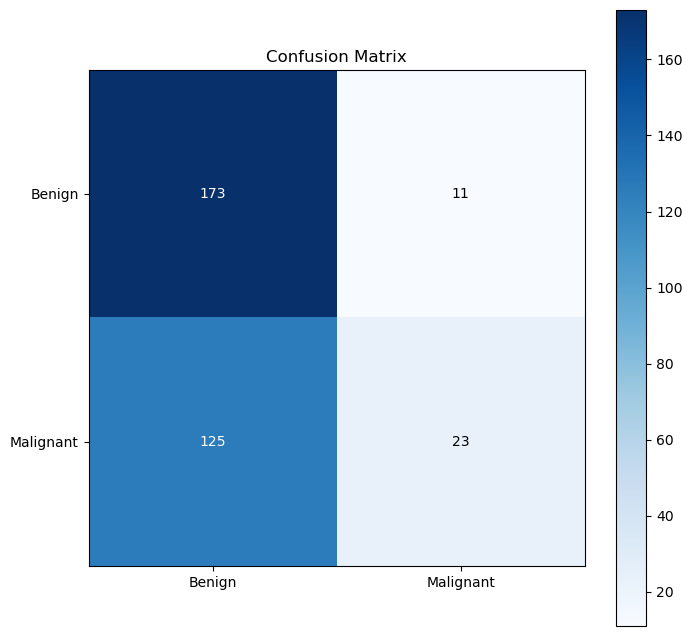

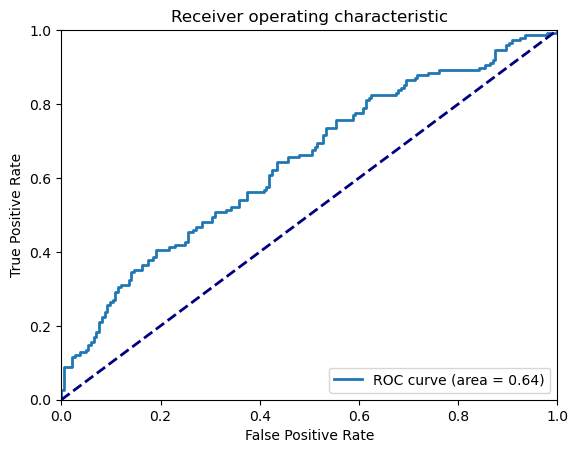

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('vgg16',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final/Final',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

## FT2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['sequential[0][0]']             
 ingOpLambda)                                                                                     
                                                                                              

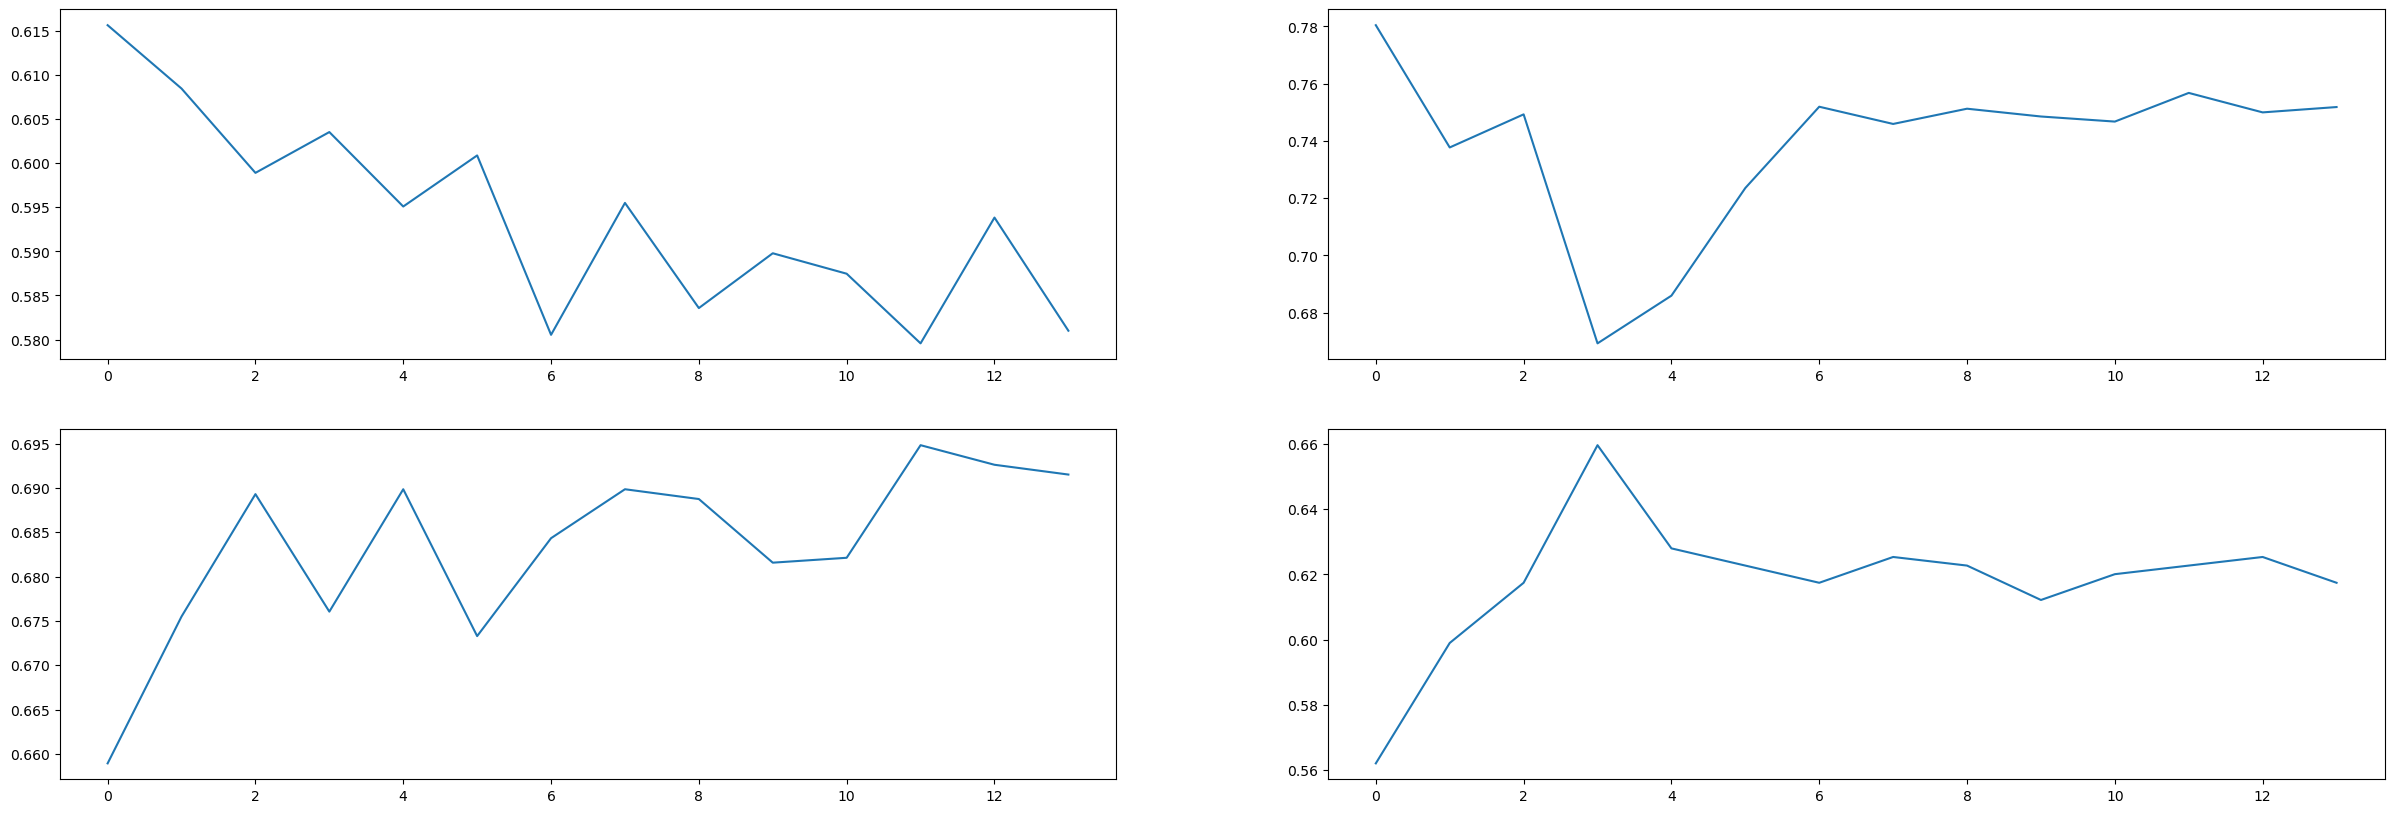

In [ ]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = -1,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'Fine_Tune_2.csv',
    load_weights = weights+'Final/Final',
    save_weights = weights+'Fine_Tune_2/best_model',
    learning_rate=1e-6,init_lr=1e-7,warmup=0,cosine=15,min_lr=1e-8,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final_2/Final_2')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_2[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                            

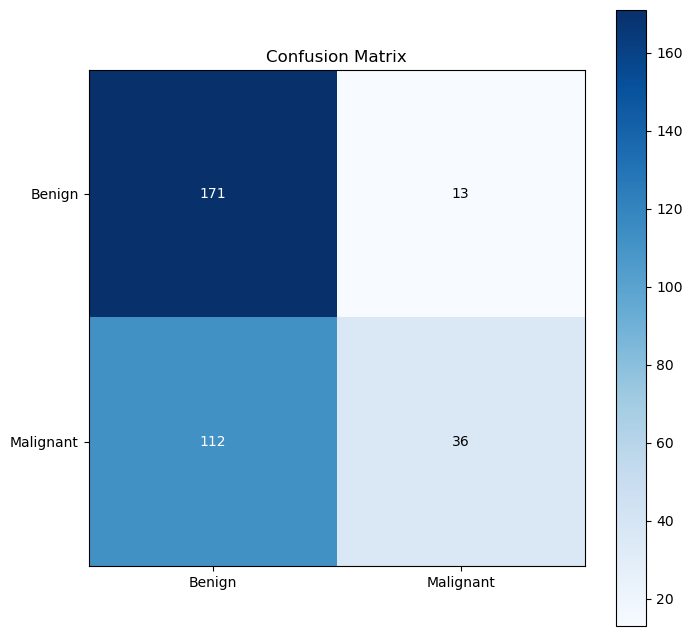

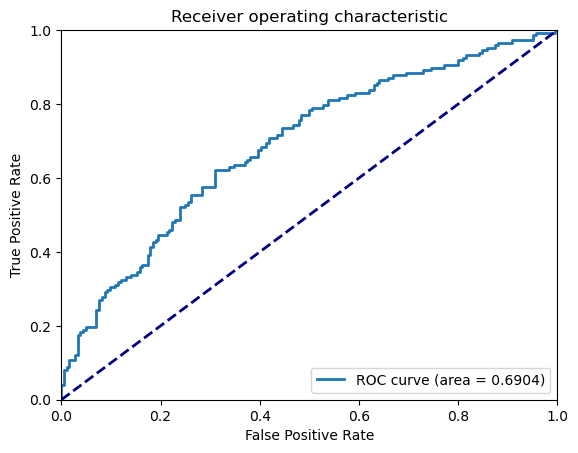

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]

model = Model_Training.build_model('vgg16',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,img_width=img_width,img_height=img_height,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

In [ ]:
# store_misclassified = misclassified_store+'vgg16/'
# model.evaluate(test)
# misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
# misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
# misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

20/20 [==============================] - 1s 52ms/step - loss: 0.5706 - categorical_accuracy: 0.6881 - precision: 0.6307 - recall: 0.5564 - auc: 0.7747

# EfficientNet

In [ ]:
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/EffcientNetB3_CBIS_DDSM/'

Cosine learning rate epochs is changed to: 0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 efficientnetb3 (Functional)    (None, 7, 7, 1536)   10783535    ['sequential[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)    

2023-03-30 10:47:21.718540: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-30 10:47:24.286832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-30 10:47:26.413250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-30 10:47:26.451231: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f88d404f720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-30 10:47:26.451258: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-30 10:47:26.468743: I tensorflow/compiler/mlir/tensorflow/u

453/453 [==============================] - ETA: 0s - loss: 91.6806 - categorical_accuracy: 0.5337 - recall: 0.2675 - recall_1: 0.7720

2023-03-30 10:47:54.919614: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 Epoch 1: accuracy=0.5337, loss=91.6806,  - lr=0.0000100
453/453 [==============================] - 43s 69ms/step - loss: 91.6806 - categorical_accuracy: 0.5337 - recall: 0.2675 - recall_1: 0.7720 - val_loss: 80.9656 - val_categorical_accuracy: 0.5356 - val_recall: 0.6592 - val_recall_1: 0.4250
Epoch 2/2
453/453 [==============================] - 30s 65ms/step - loss: 30.5404 - categorical_accuracy: 0.5877 - recall: 0.4953 - recall_1: 0.6705 - val_loss: 7.2406 - val_categorical_accuracy: 0.5805 - val_recall: 0.9106 - val_recall_1: 0.2850
Epoch 3/3
453/453 [==============================] - 30s 65ms/step - loss: 1.8790 - categorical_accuracy: 0.5762 - recall: 0.5140 - recall_1: 0.6318 - val_loss: 0.6869 - val_categorical_accuracy: 0.6623 - val_recall: 0.5810 - val_recall_1: 0.7350
Epoch 4/4
453/453 [==============================] - 30s 65ms/step - loss: 0.6991 - categorical_accuracy: 0.5712 - recall: 0.5047 - recall_1: 0.6308 - val_loss: 0.6786 - val_categorical_accuracy: 0.5910 - val_

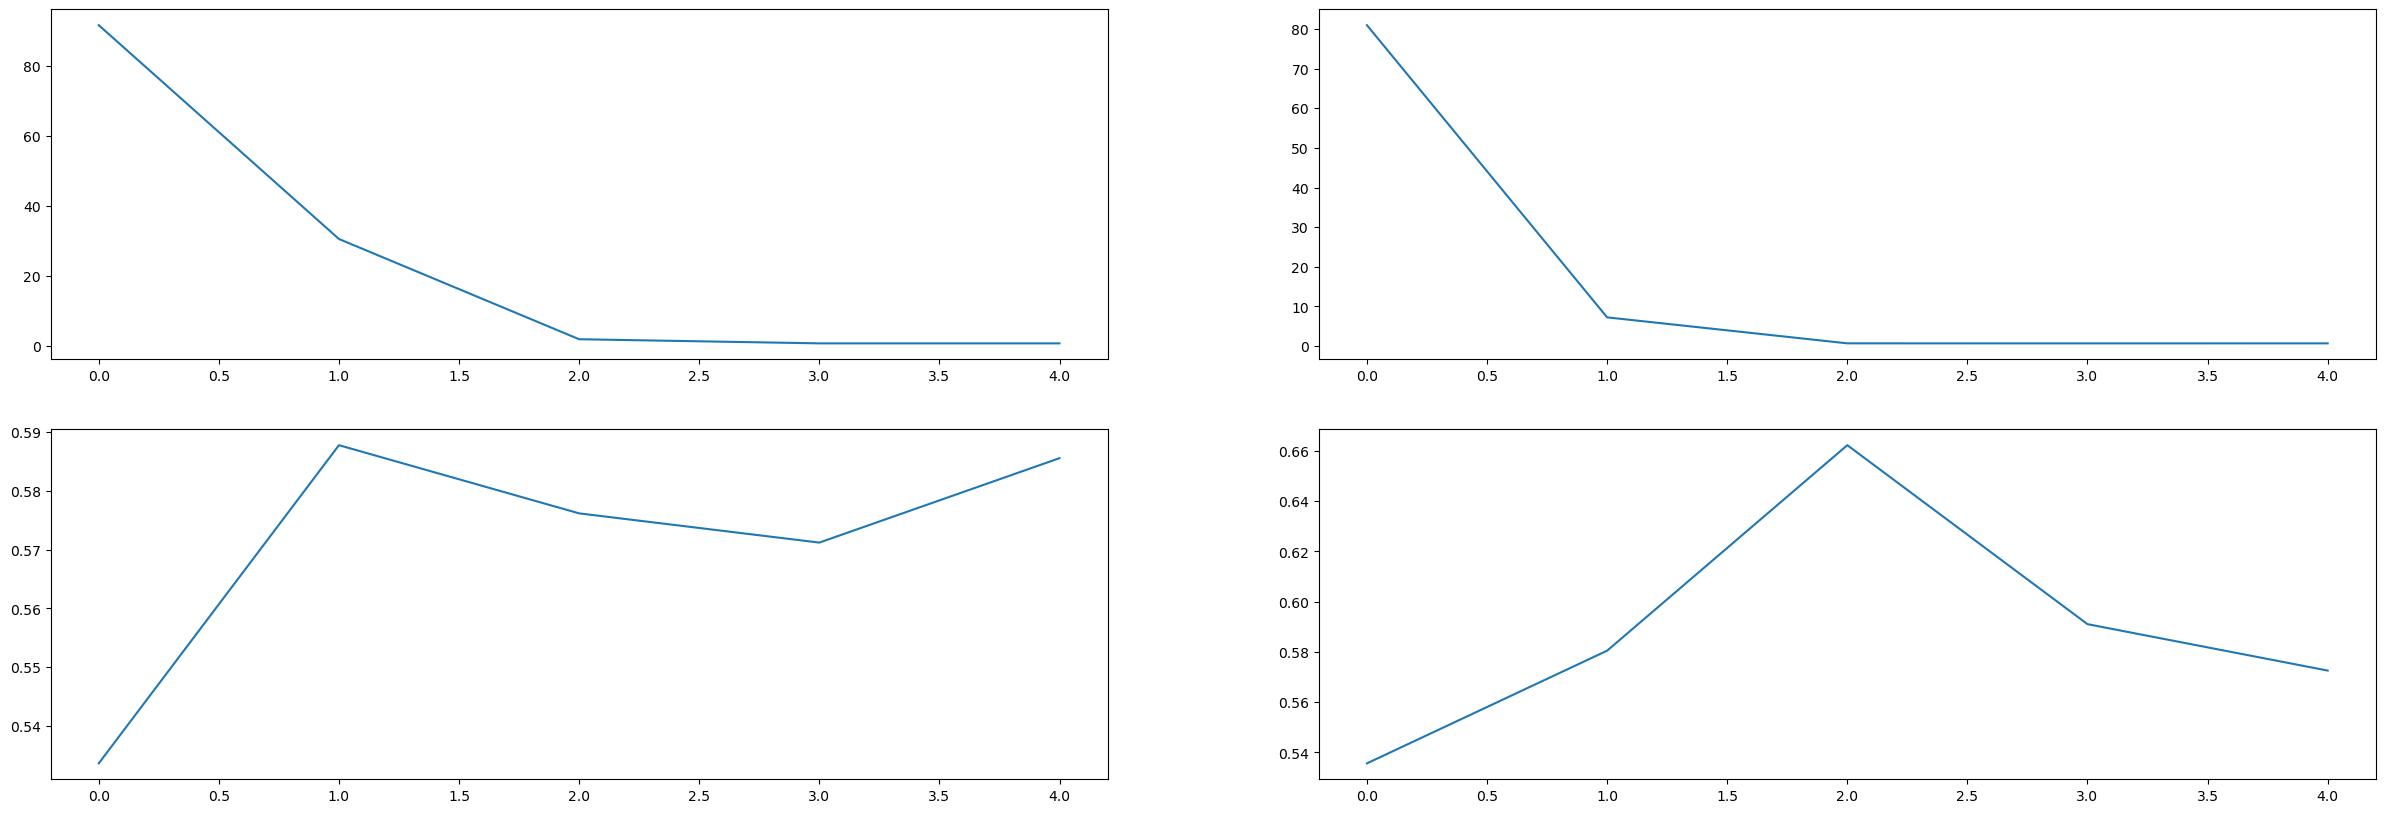

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/EffcientNetB3_CBIS_DDSM/'
model, effnet_dense_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=5,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    trainable_layers = False,flatten='global_average_pooling',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'WarmUP/best_model',
    learning_rate=5e-4,init_lr=1e-5,warmup=5,cosine=50,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 efficientnetb3 (Functional)    (None, 7, 7, 1536)   10783535    ['sequential[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['efficientnetb3[0][0]']     

2023-03-30 10:50:14.383430: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


453/453 [==============================] - ETA: 0s - loss: 0.7026 - categorical_accuracy: 0.6004 - recall: 0.5187 - recall_1: 0.6736

2023-03-30 10:50:43.441419: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 Epoch 1: accuracy=0.6004, loss=0.7026,  - lr=0.0005000
453/453 [==============================] - 39s 67ms/step - loss: 0.7026 - categorical_accuracy: 0.6004 - recall: 0.5187 - recall_1: 0.6736 - val_loss: 0.6743 - val_categorical_accuracy: 0.6544 - val_recall: 0.8547 - val_recall_1: 0.4750
Epoch 2/2
453/453 [==============================] - 30s 64ms/step - loss: 0.6988 - categorical_accuracy: 0.5894 - recall: 0.5409 - recall_1: 0.6328 - val_loss: 0.6377 - val_categorical_accuracy: 0.6412 - val_recall: 0.4749 - val_recall_1: 0.7900
Epoch 3/3
453/453 [==============================] - 30s 64ms/step - loss: 0.6856 - categorical_accuracy: 0.5971 - recall: 0.4533 - recall_1: 0.7259 - val_loss: 0.7117 - val_categorical_accuracy: 0.5198 - val_recall: 0.5307 - val_recall_1: 0.5100
Epoch 4/4
453/453 [==============================] - 30s 64ms/step - loss: 0.6770 - categorical_accuracy: 0.5938 - recall: 0.5093 - recall_1: 0.6695 - val_loss: 0.6497 - val_categorical_accuracy: 0.6359 - val_reca

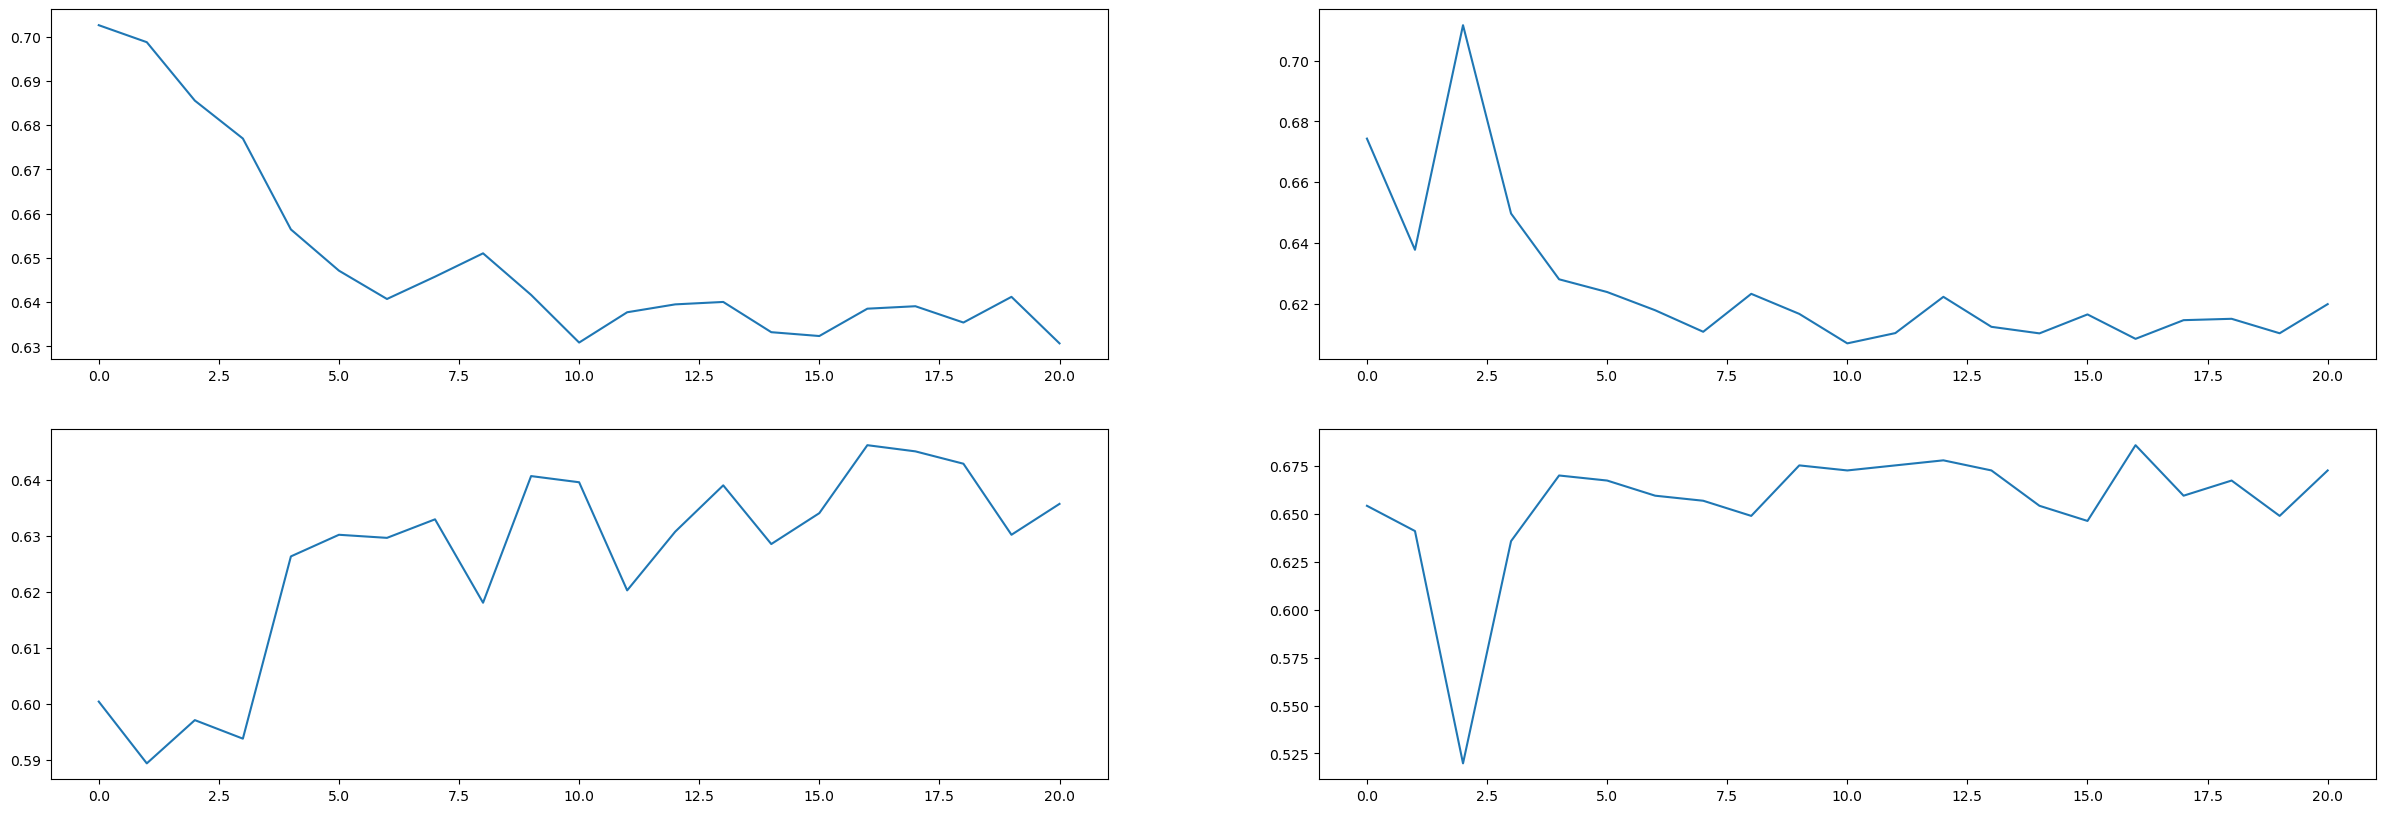

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/EffcientNetB3_CBIS_DDSM/'
model, effnet_dense_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    trainable_layers = False,flatten='global_average_pooling',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = weights+'WarmUP/best_model',
    save_weights = weights+'Dense/best_model',
    learning_rate=5e-4,init_lr=1e-5,warmup=0,cosine=50,min_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
tf.keras.backend.clear_session()

## Fine Tune

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 efficientnetb3 (Functional)    (None, 7, 7, 1536)   10783535    ['sequential[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['efficientnetb3[0][0]']     

2023-03-30 11:01:05.680924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


453/453 [==============================] - ETA: 0s - loss: 0.6727 - categorical_accuracy: 0.5993 - recall: 0.5421 - recall_1: 0.6506

2023-03-30 11:01:40.708111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 Epoch 1: accuracy=0.5993, loss=0.6727,  - lr=0.0000500
453/453 [==============================] - 45s 75ms/step - loss: 0.6727 - categorical_accuracy: 0.5993 - recall: 0.5421 - recall_1: 0.6506 - val_loss: 0.5873 - val_categorical_accuracy: 0.7045 - val_recall: 0.7765 - val_recall_1: 0.6400
Epoch 2/2
453/453 [==============================] - 34s 73ms/step - loss: 0.6415 - categorical_accuracy: 0.6187 - recall: 0.5678 - recall_1: 0.6642 - val_loss: 0.5986 - val_categorical_accuracy: 0.6913 - val_recall: 0.6201 - val_recall_1: 0.7550
Epoch 3/3
453/453 [==============================] - 34s 73ms/step - loss: 0.6208 - categorical_accuracy: 0.6501 - recall: 0.6460 - recall_1: 0.6538 - val_loss: 0.6439 - val_categorical_accuracy: 0.6702 - val_recall: 0.8492 - val_recall_1: 0.5100
Epoch 4/4
453/453 [==============================] - 34s 73ms/step - loss: 0.6134 - categorical_accuracy: 0.6634 - recall: 0.5911 - recall_1: 0.7280 - val_loss: 0.5879 - val_categorical_accuracy: 0.7018 - val_reca

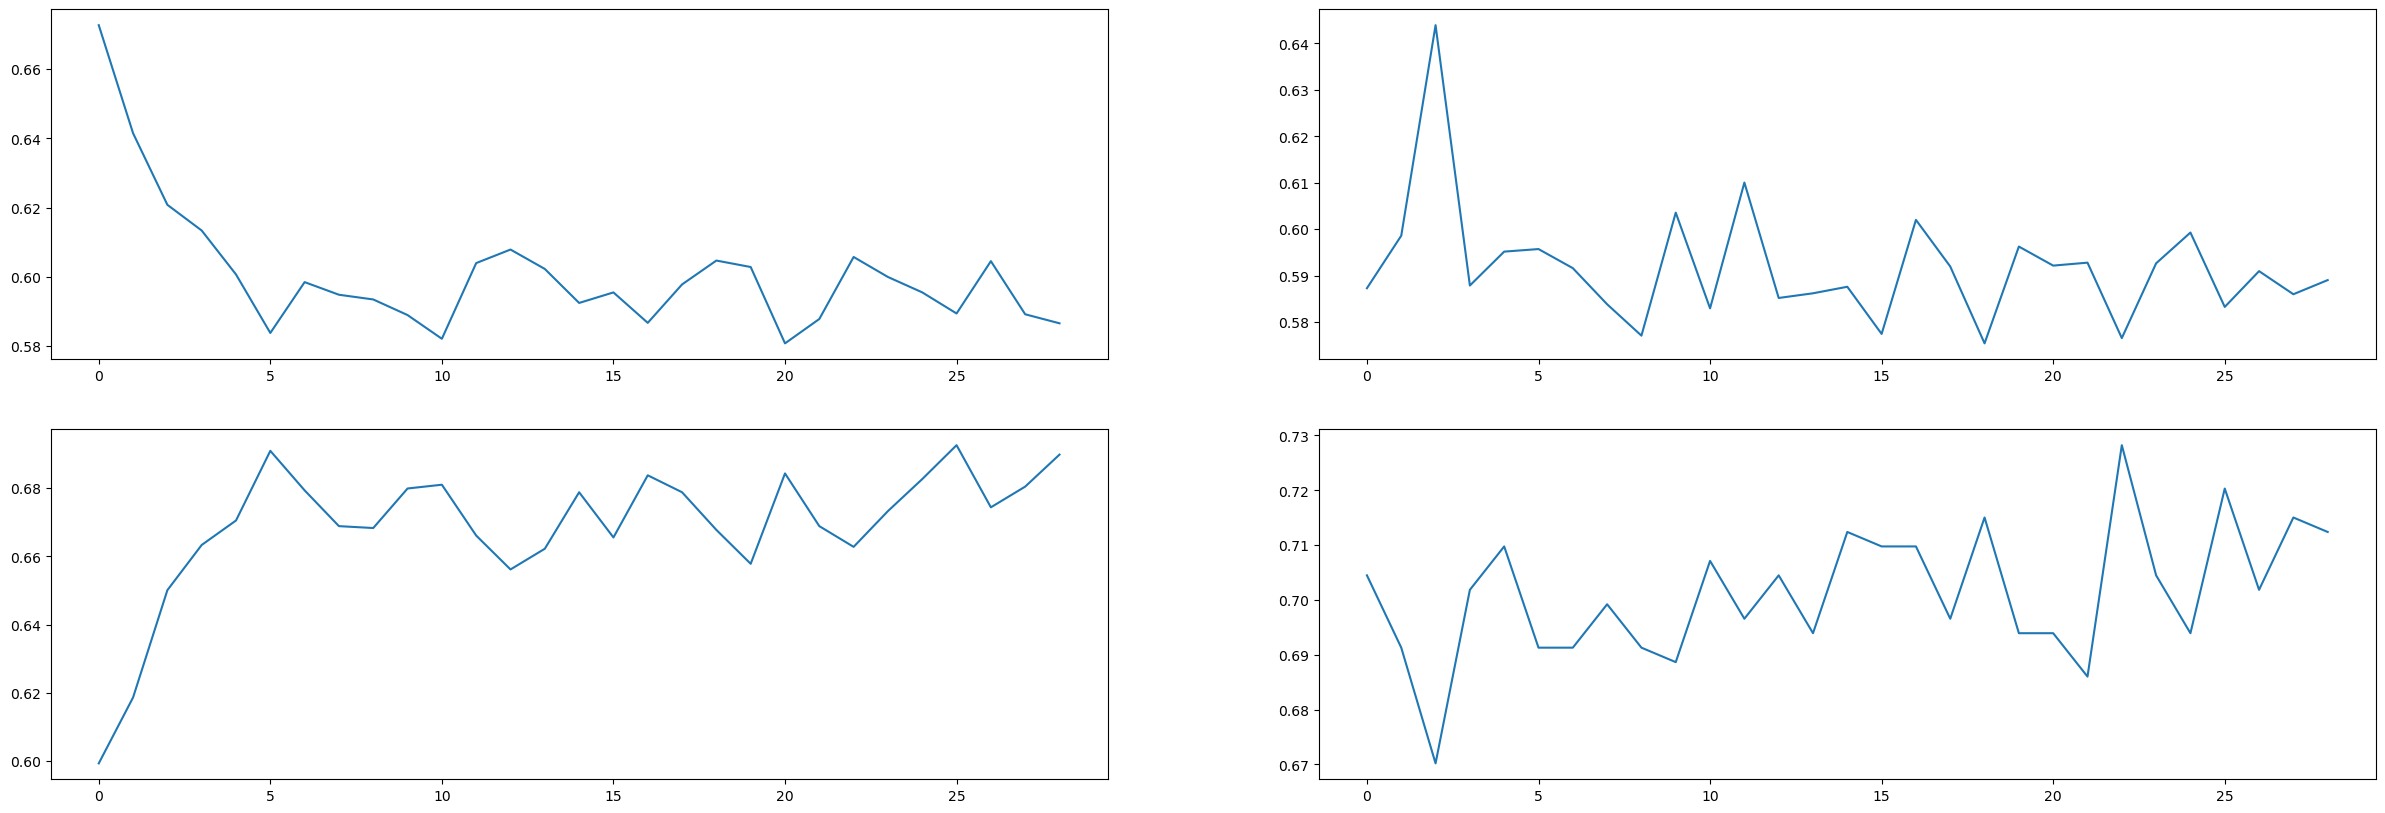

In [ ]:
tf.keras.backend.clear_session()
model, effnet_fine_tune_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    trainable_layers = 75,flatten='global_average_pooling',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=5e-5,init_lr=1e-5,warmup=0,cosine=50,min_lr=1e-7,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

## Test

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb3 (Functional)    (None, 7, 7, 1536)   10783535    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['efficientnetb3[0][0]']         
 alAveragePooling2D)                                                                              
                                                                                              

2023-03-30 11:17:40.828626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 [==============================] - 4s 29ms/step - loss: 0.6076 - categorical_accuracy: 0.7139 - precision: 0.7265 - recall: 0.5743 - auc: 0.7570


2023-03-30 11:17:44.581858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 [==============================] - 3s 23ms/step


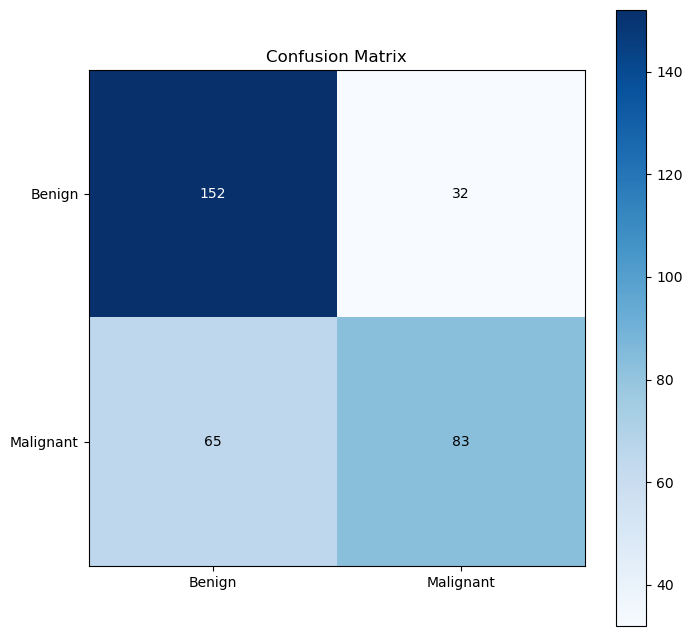

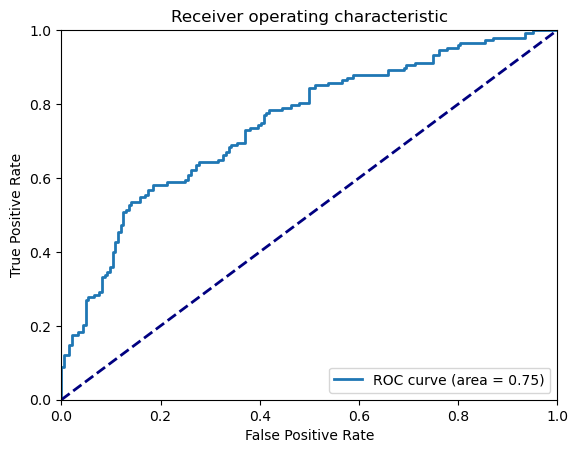

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetb3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final/Final',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

## FT2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 efficientnetb3 (Functional)    (None, 7, 7, 1536)   10783535    ['sequential[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['efficientnetb3[0][0]']     

2023-03-30 11:18:03.475252: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


453/453 [==============================] - ETA: 0s - loss: 0.6052 - categorical_accuracy: 0.6634 - precision: 0.6349 - precision_1: 0.6922

2023-03-30 11:19:03.461998: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 Epoch 1: accuracy=0.6634, loss=0.6052,  - lr=0.0000050
453/453 [==============================] - 73s 110ms/step - loss: 0.6052 - categorical_accuracy: 0.6634 - precision: 0.6349 - precision_1: 0.6922 - val_loss: 0.6819 - val_categorical_accuracy: 0.6702 - val_precision: 0.5951 - val_precision_1: 0.8947
Epoch 2/2
453/453 [==============================] - 49s 107ms/step - loss: 0.5935 - categorical_accuracy: 0.6738 - precision: 0.6490 - precision_1: 0.6977 - val_loss: 0.5741 - val_categorical_accuracy: 0.7256 - val_precision: 0.6623 - val_precision_1: 0.8243
Epoch 3/3
453/453 [==============================] - 50s 107ms/step - loss: 0.5862 - categorical_accuracy: 0.6766 - precision: 0.6559 - precision_1: 0.6956 - val_loss: 0.5918 - val_categorical_accuracy: 0.7467 - val_precision: 0.6736 - val_precision_1: 0.8714
Epoch 4/4
453/453 [==============================] - 49s 107ms/step - loss: 0.5716 - categorical_accuracy: 0.6981 - precision: 0.6746 - precision_1: 0.7206 - val_loss: 0.5600

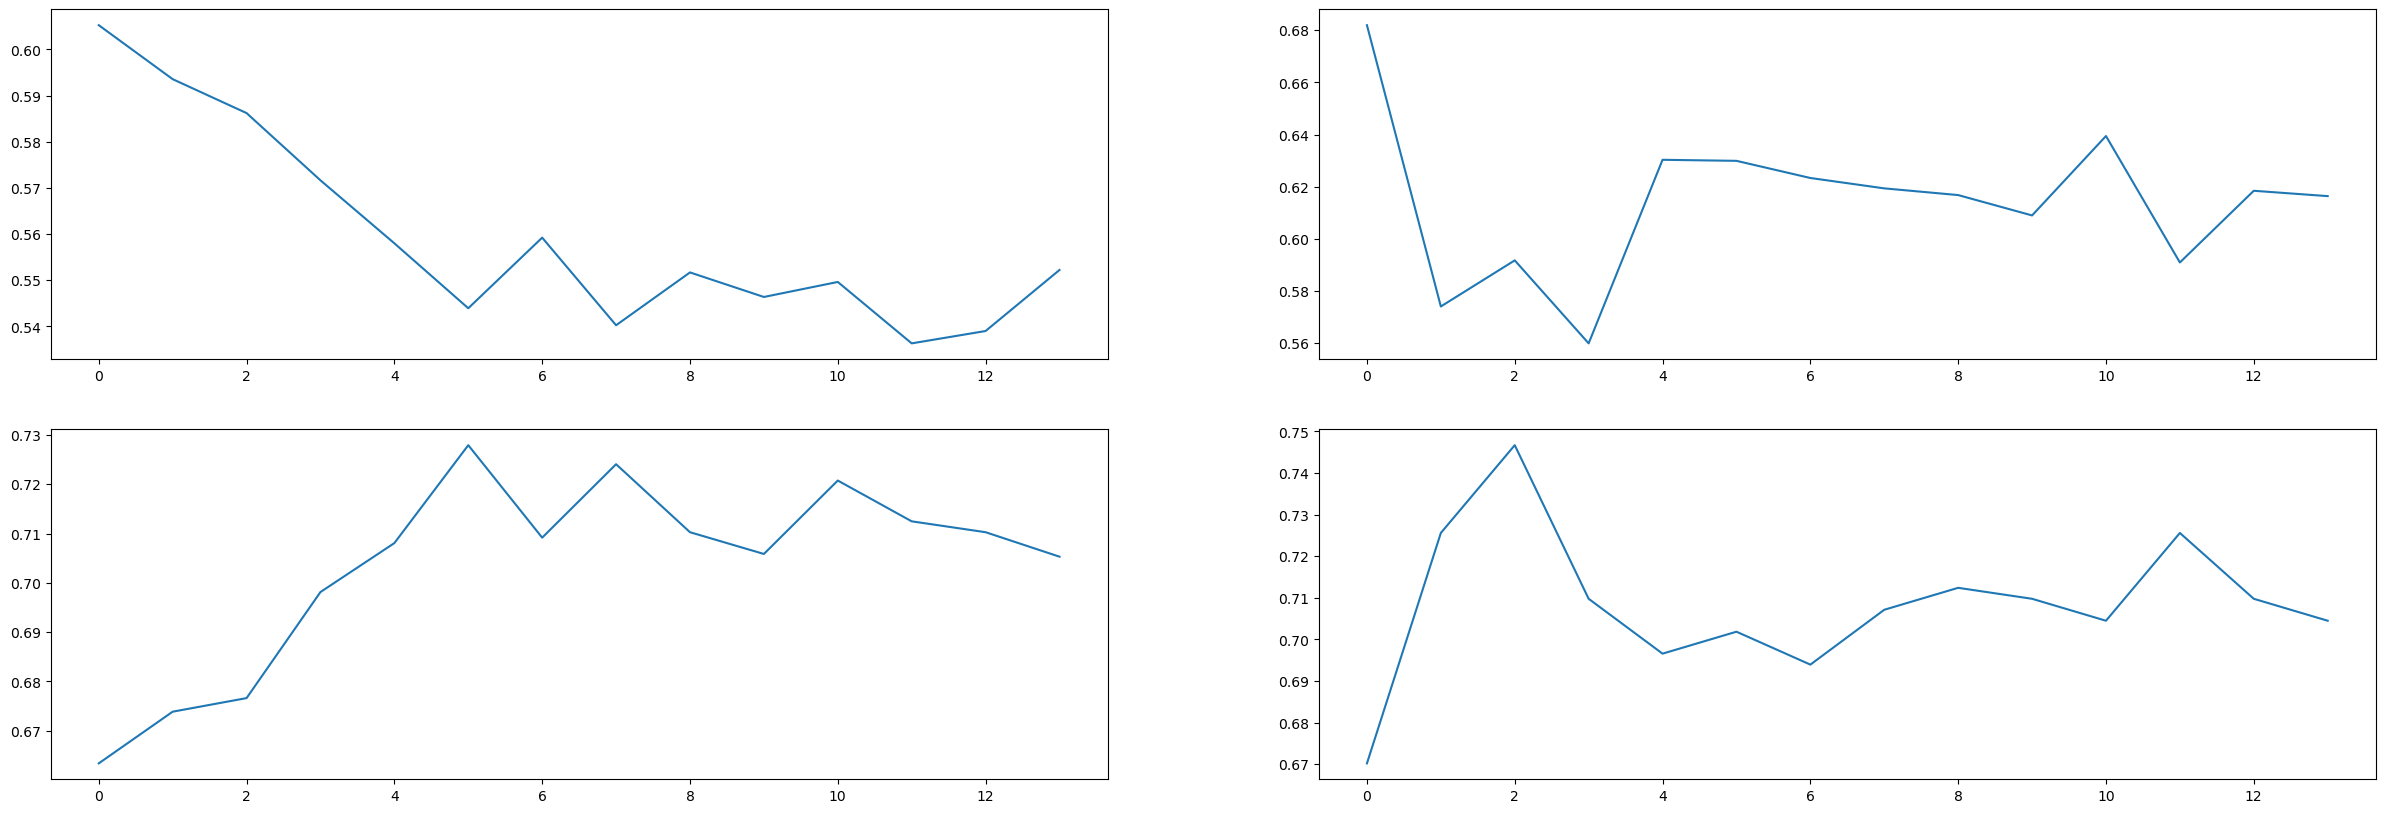

In [ ]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = -1,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'Fine_Tune_2.csv',
    load_weights = weights+'Final/Final',
    save_weights = weights+'Fine_Tune_2/best_model',
    learning_rate=5e-6,init_lr=1e-7,warmup=0,cosine=15,min_lr=1e-8,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final_2/Final_2')

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetb3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,img_width=img_width,img_height=img_height,training=False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb3 (Functional)    (None, 7, 7, 1536)   10783535    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['efficientnetb3[0][0]']         
 alAveragePooling2D)                                                                              
                                                                                              

In [ ]:
# store_misclassified = misclassified_store+'efficientnetb3/'
# model.evaluate(test)
# misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
# misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
# misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

83/83 [==============================] - 3s 26ms/step


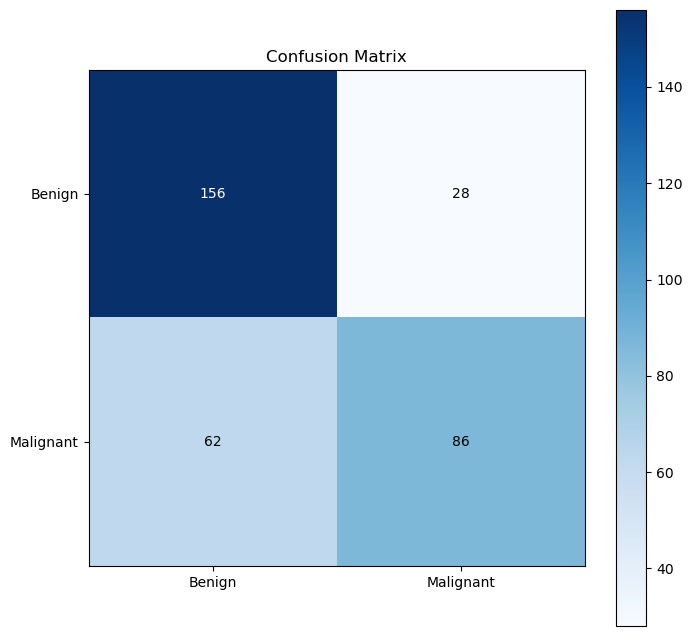

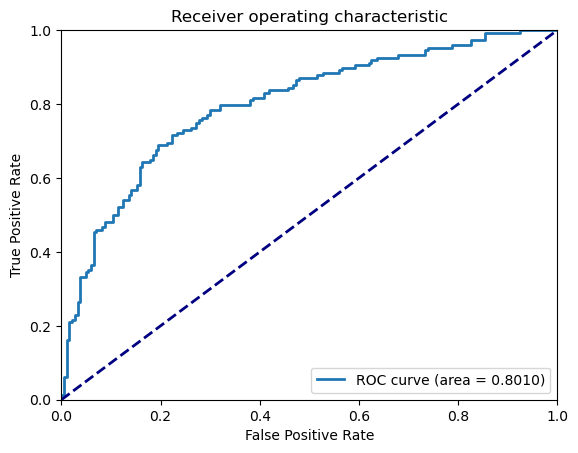

In [ ]:
# model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

20/20 [==============================] - 2s 68ms/step - loss: 0.5899 - categorical_accuracy: 0.6849 - precision: 0.6400 - recall: 0.3015 - auc: 0.7611

# ConvNext

In [ ]:
weights = '/home/jj/FYP/Checkpoint/Convnext_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Convnext_CBIS_DDSM/'

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 convnext_base (Functional)     (None, 7, 7, 1024)   87566464    ['sequential[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1024)        0           ['convnext_base[0][0]']      

2023-03-29 19:16:36.319172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-29 19:16:37.719162: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe4e0b2cf50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-29 19:16:37.719196: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-29 19:16:38.238914: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-29 19:16:38.241072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-29 19:16:39.953243: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECT

453/453 [==============================] - 82s 147ms/step - loss: 92.1236 - categorical_accuracy: 0.5193 - precision: 0.4877 - precision_1: 0.5353 - val_loss: 81.6223 - val_categorical_accuracy: 0.5172 - val_precision: 0.4892 - val_precision_1: 0.5440
Epoch 2/2
453/453 [==============================] - 63s 137ms/step - loss: 30.6095 - categorical_accuracy: 0.5497 - precision: 0.5270 - precision_1: 0.5654 - val_loss: 7.2198 - val_categorical_accuracy: 0.6491 - val_precision: 0.5943 - val_precision_1: 0.7481
Epoch 3/3
453/453 [==============================] - 63s 136ms/step - loss: 1.9451 - categorical_accuracy: 0.5706 - precision: 0.5494 - precision_1: 0.5871 - val_loss: 0.6964 - val_categorical_accuracy: 0.6623 - val_precision: 0.6349 - val_precision_1: 0.6895
Epoch 4/4
453/453 [==============================] - 64s 140ms/step - loss: 0.6959 - categorical_accuracy: 0.5778 - precision: 0.5578 - precision_1: 0.5932 - val_loss: 0.6521 - val_categorical_accuracy: 0.6491 - val_precision: 

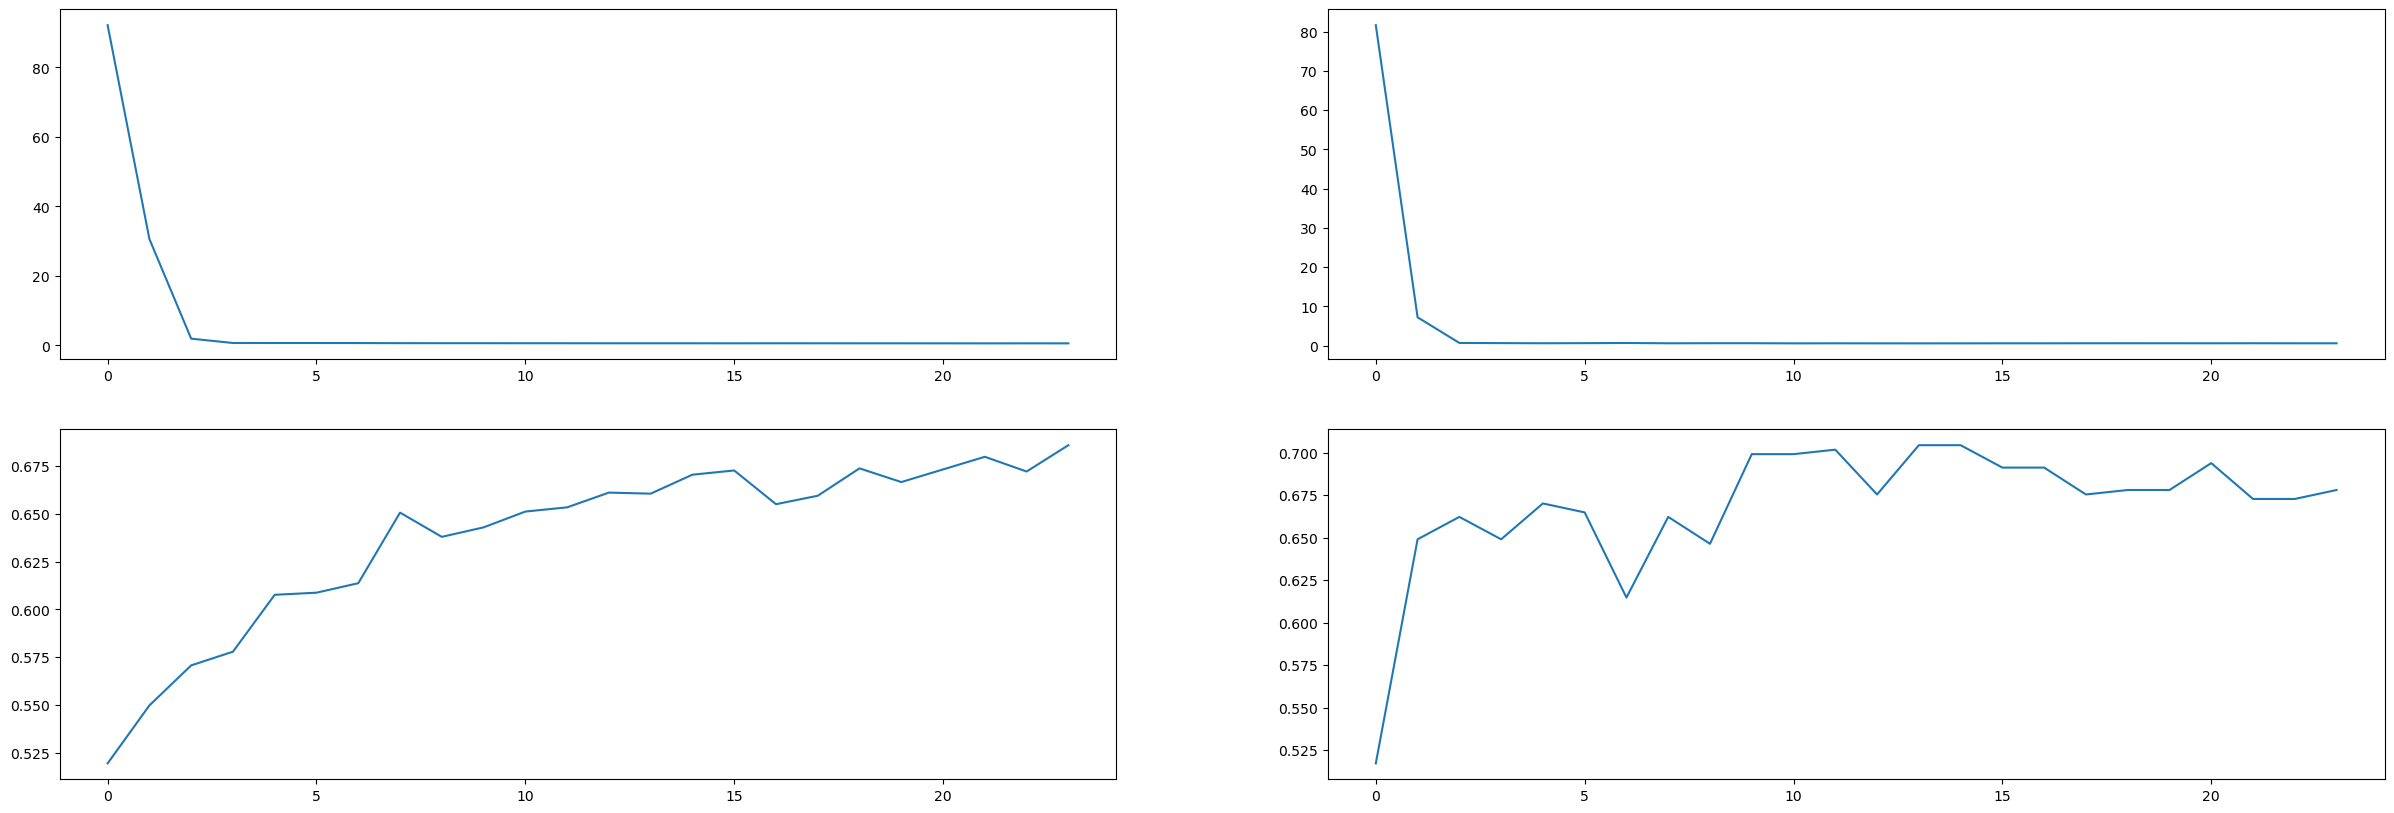

In [ ]:
tf.keras.backend.clear_session()
model, convnext_dense_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    trainable_layers = False,flatten='global_average_pooling',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=5e-4,init_lr=1e-5,warmup=5,cosine=50,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 convnext_base (Functional)     (None, 7, 7, 1024)   87566464    ['sequential[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1024)        0           ['convnext_base[0][0]']      

2023-03-29 21:44:55.976354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-29 21:44:58.166357: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2a93a205d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-29 21:44:58.166388: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-29 21:44:58.841024: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-29 21:44:58.846448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-29 21:45:00.591700: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECT

453/453 [==============================] - 89s 155ms/step - loss: 0.6752 - categorical_accuracy: 0.6098 - precision: 0.5939 - precision_1: 0.6222 - val_loss: 0.5870 - val_categorical_accuracy: 0.6860 - val_precision: 0.6351 - val_precision_1: 0.7580
Epoch 2/2
453/453 [==============================] - 67s 144ms/step - loss: 0.6270 - categorical_accuracy: 0.6451 - precision: 0.6113 - precision_1: 0.6830 - val_loss: 0.5791 - val_categorical_accuracy: 0.6887 - val_precision: 0.6380 - val_precision_1: 0.7595
Epoch 3/3
453/453 [==============================] - 66s 144ms/step - loss: 0.6131 - categorical_accuracy: 0.6518 - precision: 0.6347 - precision_1: 0.6663 - val_loss: 0.6145 - val_categorical_accuracy: 0.7045 - val_precision: 0.6618 - val_precision_1: 0.7558
Epoch 4/4
453/453 [==============================] - 66s 143ms/step - loss: 0.6015 - categorical_accuracy: 0.6656 - precision: 0.6680 - precision_1: 0.6639 - val_loss: 0.5974 - val_categorical_accuracy: 0.6913 - val_precision: 0.6

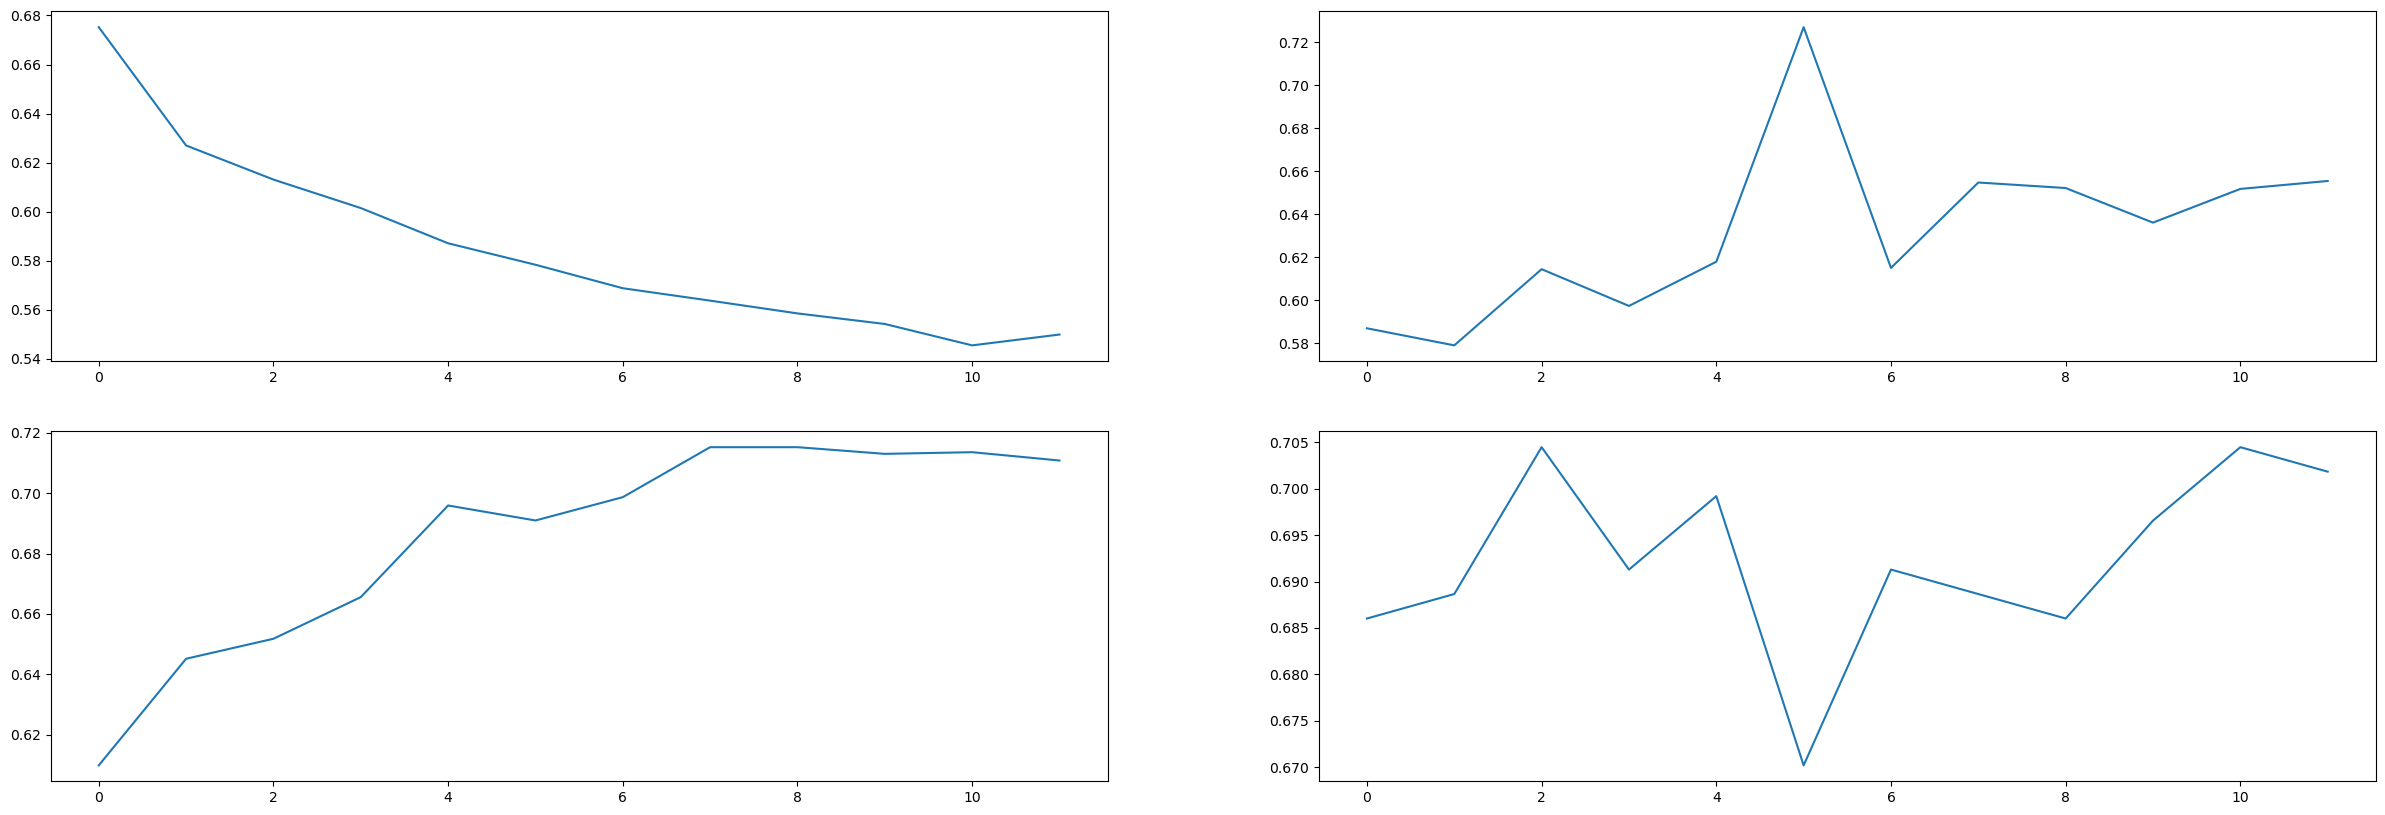

In [ ]:
tf.keras.backend.clear_session()
model, convnext_fine_tune_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    # Top 25 layers are the stage 3 blocks
    trainable_layers = 25, flatten='global_average_pooling',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=5e-5,init_lr=1e-5,warmup=0,cosine=50,min_lr=1e-7,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

## Test

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base (Functional)     (None, 7, 7, 1024)   87566464    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1024)        0           ['convnext_base[0][0]']          
 alAveragePooling2D)                                                                              
                                                                                              

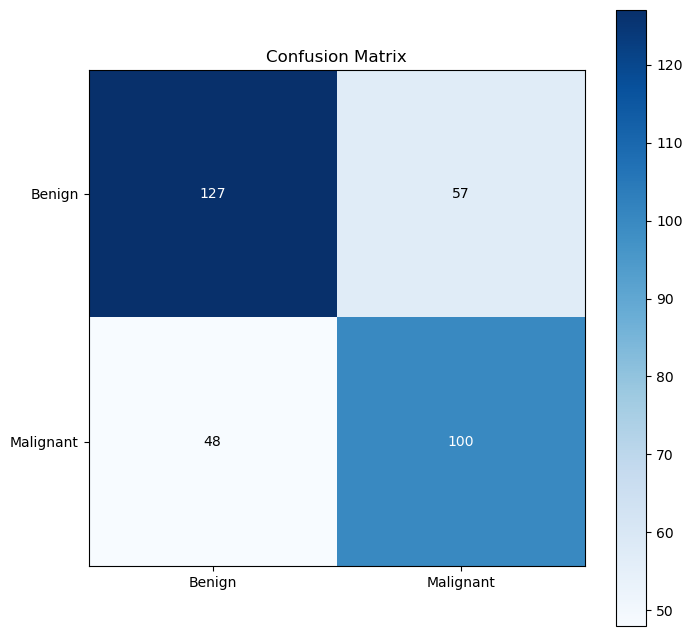

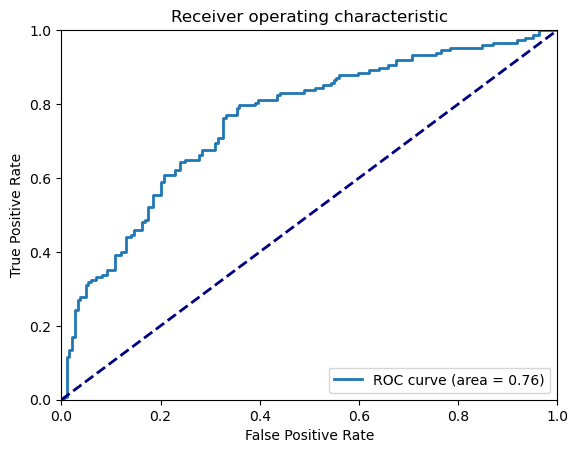

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('convnext',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric,img_height=img_height,img_width=img_width)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

## FT2

In [ ]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = -1,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'Fine_Tune_2.csv',
    load_weights = weights+'Fine_Tune/best_model',
    save_weights = weights+'Fine_Tune_2/best_model',
    learning_rate=5e-6,init_lr=1e-7,warmup=0,cosine=15,min_lr=1e-8,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()], plot=False,
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final_2/Final_2')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 convnext_base (Functional)     (None, 7, 7, 1024)   87566464    ['sequential[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1024)        0           ['convnext_base[0][0]']      

2023-03-30 13:39:22.625879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 539 of 1024
2023-03-30 13:39:30.590205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-03-30 13:39:31.366454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-30 13:39:32.851354: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f00d5626f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-30 13:39:32.851399: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-30 13:39:33.401883: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-30 13:39:33.407147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] T

453/453 [==============================] - ETA: 0s - loss: 0.6418 - categorical_accuracy: 0.6385 - precision: 0.6138 - precision_1: 0.6620

2023-03-30 13:41:43.924936: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-30 13:41:43.924978: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 Epoch 1: accuracy=0.6385, loss=0.6418,  - lr=0.0000050
453/453 [==============================] - 170s 255ms/step - loss: 0.6418 - categorical_accuracy: 0.6385 - precision: 0.6138 - precision_1: 0.6620 - val_loss: 0.5855 - val_categorical_accuracy: 0.6860 - val_precision: 0.6250 - val_precision_1: 0.7914
Epoch 2/2
453/453 [==============================] - 107s 233ms/step - loss: 0.5937 - categorical_accuracy: 0.6816 - precision: 0.6515 - precision_1: 0.7127 - val_loss: 0.5891 - val_categorical_accuracy: 0.7018 - val_precision: 0.6241 - val_precision_1: 0.8850
Epoch 3/3
453/453 [==============================] - 107s 234ms/step - loss: 0.5745 - categorical_accuracy: 0.6921 - precision: 0.6709 - precision_1: 0.7117 - val_loss: 0.5859 - val_categorical_accuracy: 0.7098 - val_precision: 0.6364 - val_precision_1: 0.8571
Epoch 4/4
453/453 [==============================] - 106s 232ms/step - loss: 0.5594 - categorical_accuracy: 0.7125 - precision: 0.6973 - precision_1: 0.7259 - val_loss: 0.

: 

: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base (Functional)     (None, 7, 7, 1024)   87566464    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1024)        0           ['convnext_base[0][0]']          
 alAveragePooling2D)                                                                              
                                                                                              

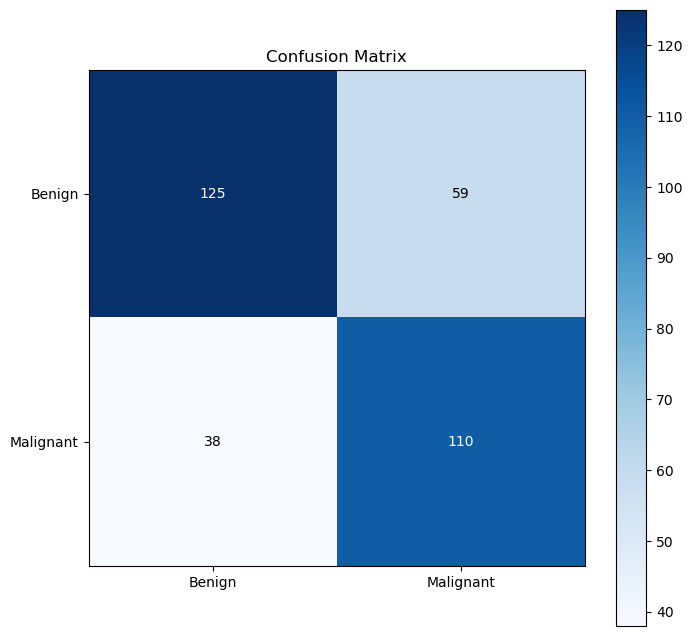

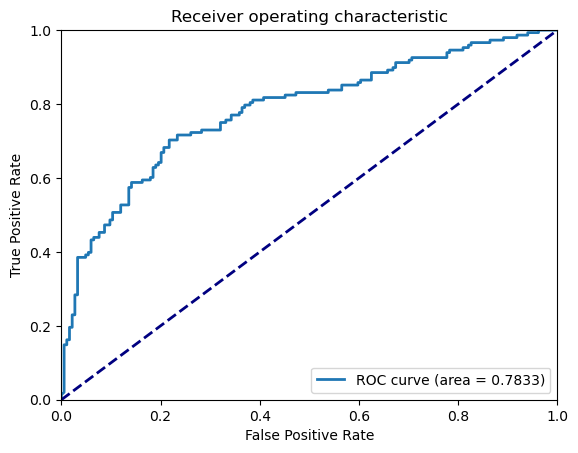

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('convnext',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

In [ ]:
# store_misclassified = misclassified_store+'convnext/'
# model.evaluate(test)
# misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
# misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
# misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')


20/20 [==============================] - 20s 458ms/step - loss: 0.5904 - categorical_accuracy: 0.7203 - precision: 0.6797 - recall: 0.6541 - auc: 0.7756

20/20 [==============================] - 5s 222ms/step - loss: 0.5724 - categorical_accuracy: 0.7267 - precision: 0.7222 - recall: 0.5865 - auc: 0.7897

# EfficientNet V2M

## Initialising

In [ ]:
weights = '/home/jj/FYP/Checkpoint/Efficientnetv2m_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Efficientnetv2m_CBIS_DDSM/'

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 efficientnetv2-m (Functional)  (None, 7, 7, 1280)   53150388    ['sequential[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnetv2-m[0][0]']   

2023-03-30 14:02:27.176982: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-30 14:02:29.840870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-30 14:02:31.503693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-30 14:02:31.629394: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa43402daa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-30 14:02:31.629425: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-30 14:02:31.636459: I tensorflow/compiler/mlir/tensorflow

453/453 [==============================] - ETA: 0s - loss: 91.5789 - categorical_accuracy: 0.4967 - precision: 0.4510 - precision_1: 0.5177

2023-03-30 14:03:08.845541: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 Epoch 1: accuracy=0.4967, loss=91.5789,  - lr=0.0000100
453/453 [==============================] - 57s 93ms/step - loss: 91.5789 - categorical_accuracy: 0.4967 - precision: 0.4510 - precision_1: 0.5177 - val_loss: 80.7014 - val_categorical_accuracy: 0.5726 - val_precision: 0.5669 - val_precision_1: 0.5754
Epoch 2/2
453/453 [==============================] - 40s 87ms/step - loss: 29.1985 - categorical_accuracy: 0.5657 - precision: 0.5533 - precision_1: 0.5725 - val_loss: 6.3002 - val_categorical_accuracy: 0.5858 - val_precision: 0.5474 - val_precision_1: 0.6463
Epoch 3/3
453/453 [==============================] - 40s 87ms/step - loss: 1.6604 - categorical_accuracy: 0.5602 - precision: 0.5428 - precision_1: 0.5708 - val_loss: 0.6723 - val_categorical_accuracy: 0.6280 - val_precision: 0.5922 - val_precision_1: 0.6705
Epoch 4/4
453/453 [==============================] - 40s 87ms/step - loss: 0.7007 - categorical_accuracy: 0.5535 - precision: 0.5310 - precision_1: 0.5698 - val_loss: 0.6776

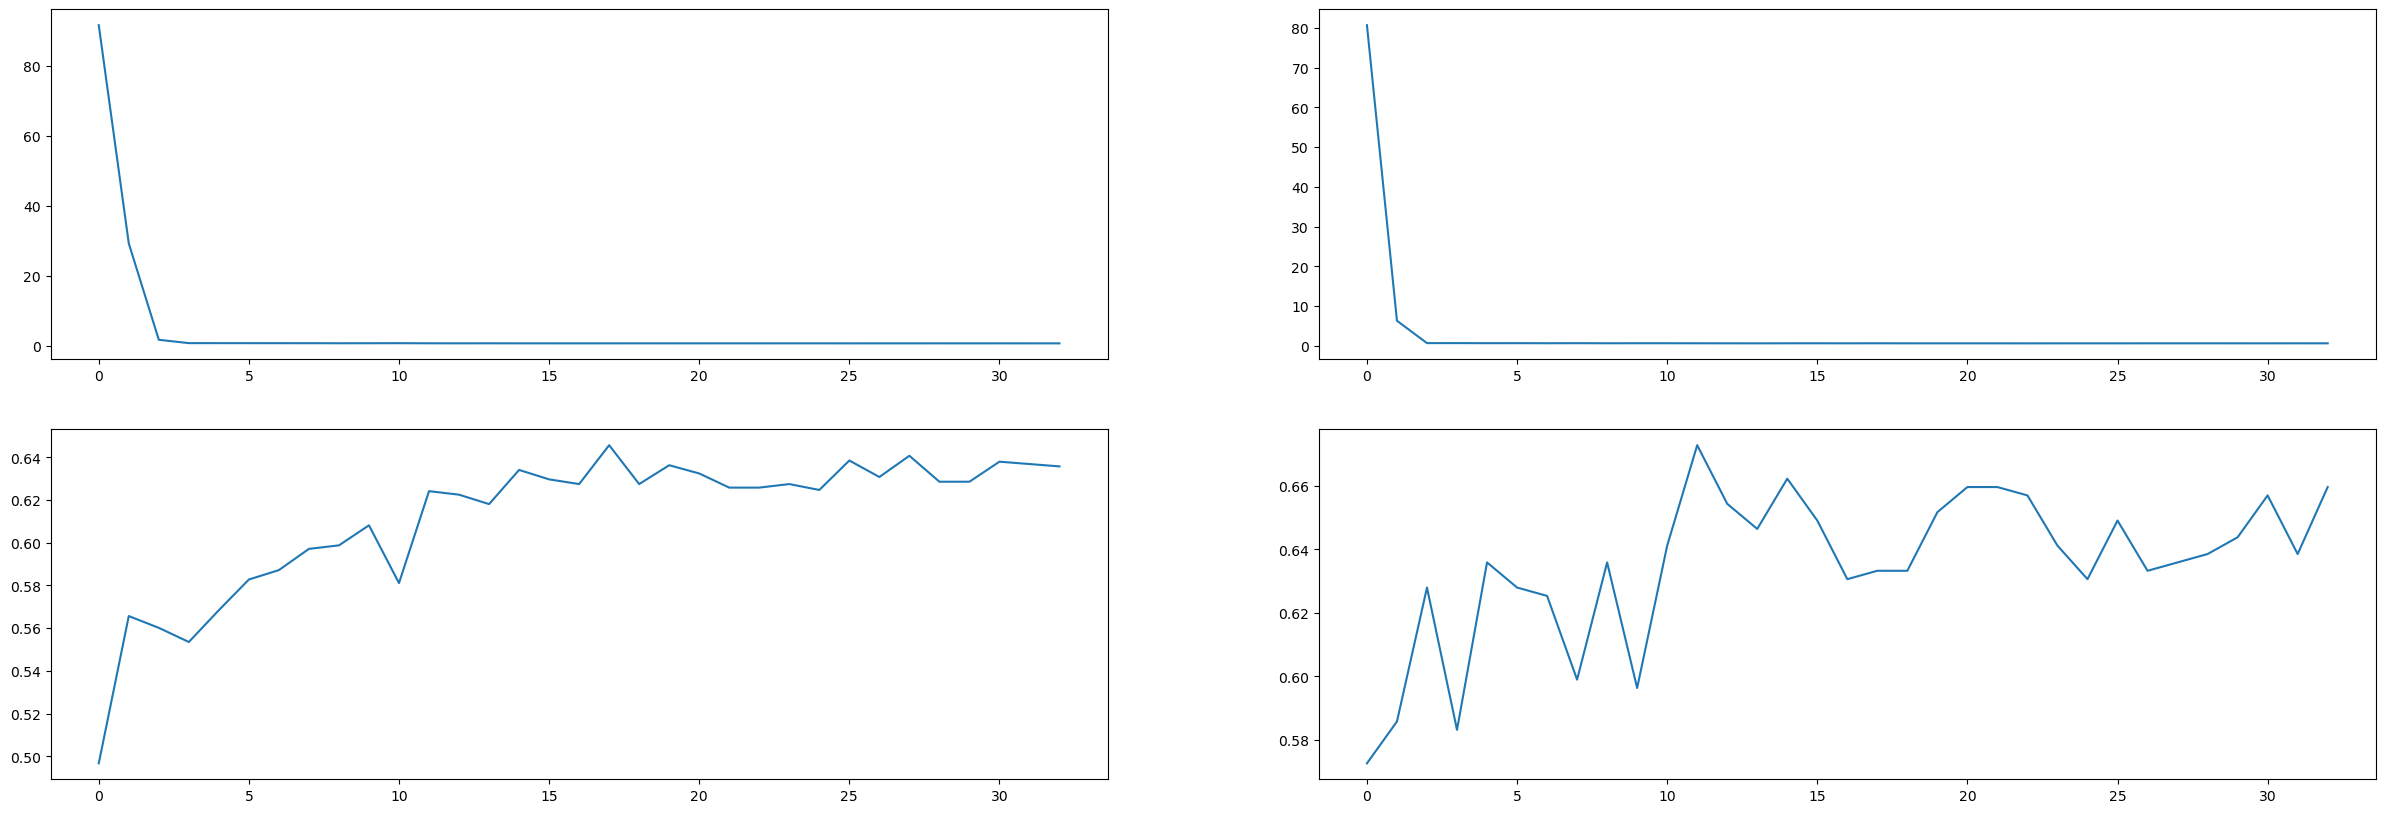

In [ ]:
tf.keras.backend.clear_session()


model, effnetv2m_dense_history = Model_Training.main(    
'efficientnetv2m',
train,
val,
epochs = 100,
patience=2,
Earlystop = 10,
augmentation = True,
trainable_layers = False,
regulariser=tf.keras.regularizers.l2(l2=0.1),
train_log= train_log+'dense.csv',
load_weights = False,
save_weights = weights+'Dense/best_model',
learning_rate=5e-4,init_lr=1e-5,warmup=5,cosine=50,
optimiser=tf.keras.optimizers.Adam(),
losses = tf.keras.losses.CategoricalCrossentropy(),
metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
callbacks = [PrintLR()],
img_height=img_height,img_width=img_width)


## Fine Tuning

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 efficientnetv2-m (Functional)  (None, 7, 7, 1280)   53150388    ['sequential[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnetv2-m[0][0]']   

2023-03-30 14:35:39.445456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-30 14:35:41.900522: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f98600158a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-30 14:35:41.900551: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-30 14:35:41.916937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-30 14:35:42.077350: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/453 [==============================] - ETA: 0s - loss: 0.7010 - categorical_accuracy: 0.5364 - precision: 0.5188 - precision_1: 0.5418

2023-03-30 14:36:24.298175: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 Epoch 1: accuracy=0.5364, loss=0.7010,  - lr=0.0000500
453/453 [==============================] - 61s 100ms/step - loss: 0.7010 - categorical_accuracy: 0.5364 - precision: 0.5188 - precision_1: 0.5418 - val_loss: 0.6863 - val_categorical_accuracy: 0.5277 - val_precision: 0.5000 - val_precision_1: 0.8621
Epoch 2/2
453/453 [==============================] - 43s 93ms/step - loss: 0.6694 - categorical_accuracy: 0.6336 - precision: 0.6157 - precision_1: 0.6487 - val_loss: 0.6068 - val_categorical_accuracy: 0.6596 - val_precision: 0.6096 - val_precision_1: 0.7351
Epoch 3/3
453/453 [==============================] - 43s 93ms/step - loss: 0.6556 - categorical_accuracy: 0.6269 - precision: 0.6119 - precision_1: 0.6389 - val_loss: 0.6566 - val_categorical_accuracy: 0.6675 - val_precision: 0.6233 - val_precision_1: 0.7256
Epoch 4/4
453/453 [==============================] - 43s 93ms/step - loss: 0.6315 - categorical_accuracy: 0.6413 - precision: 0.6281 - precision_1: 0.6518 - val_loss: 0.6120 - 

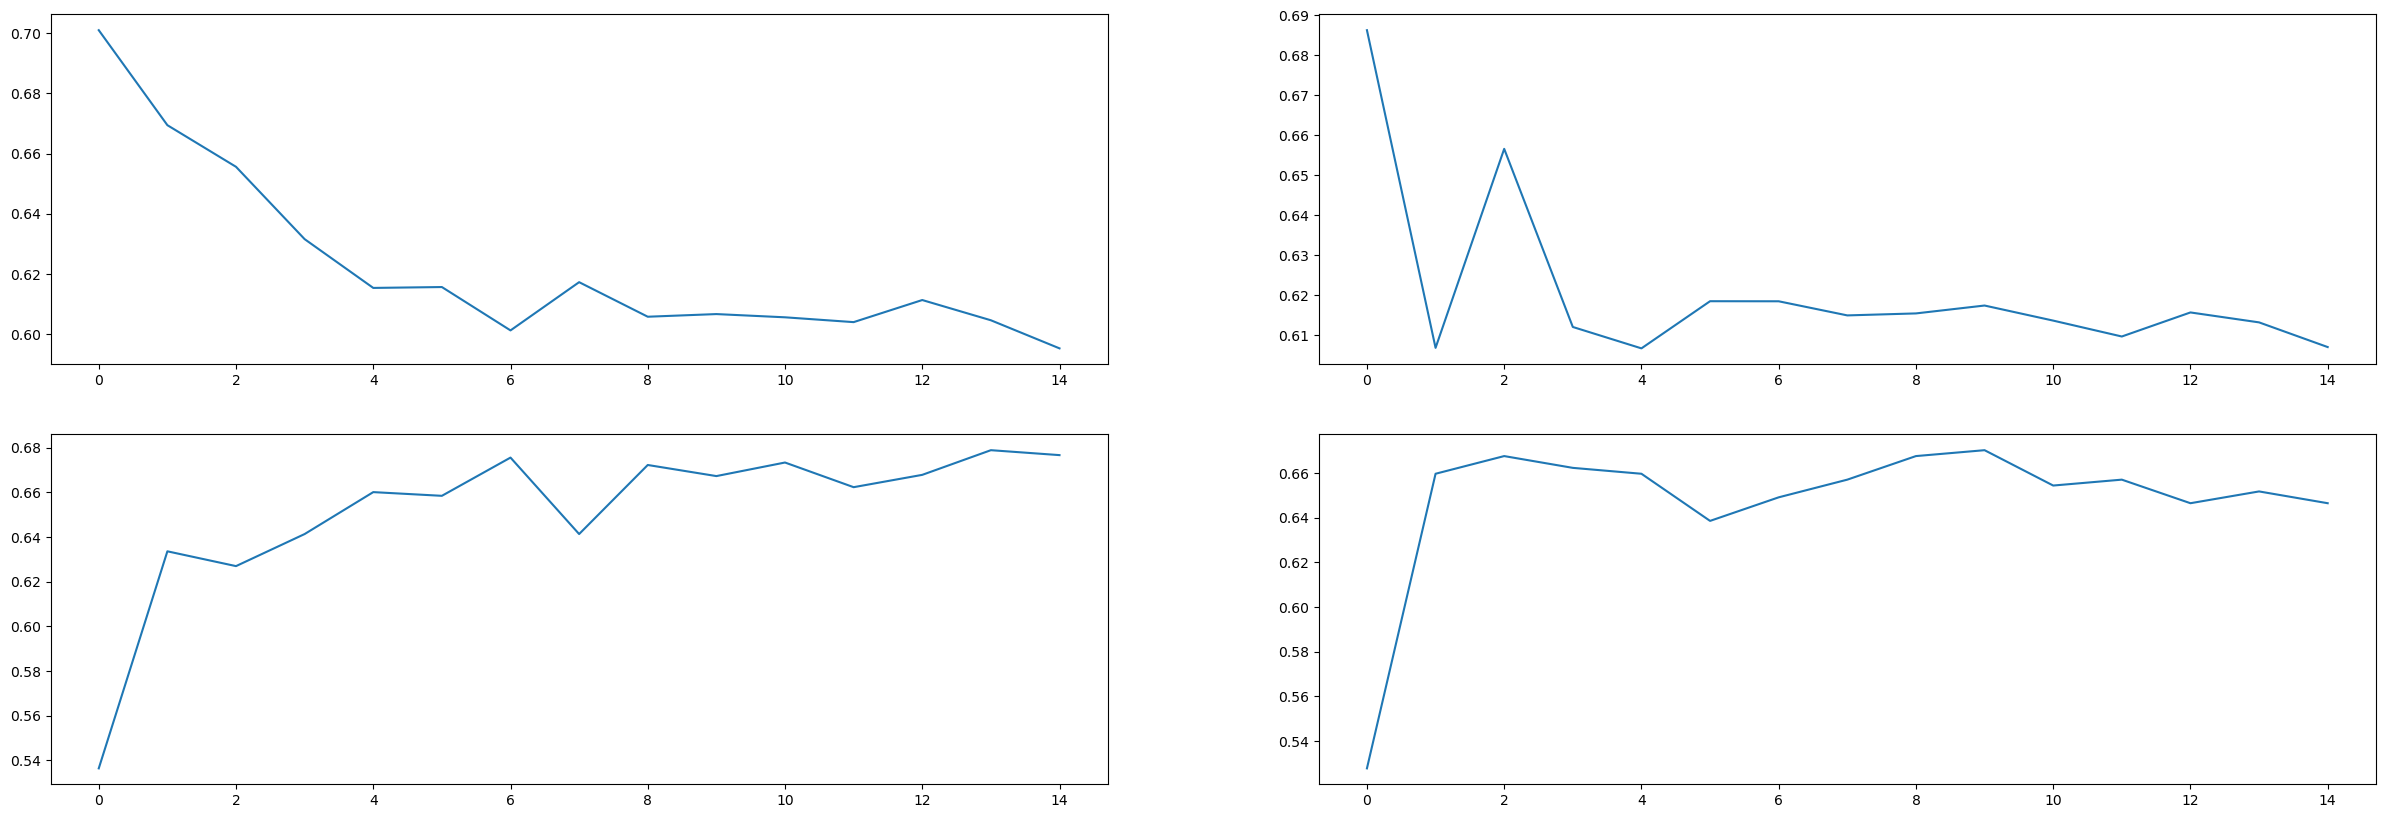

In [ ]:
tf.keras.backend.clear_session()
model, effnetv2m_fine_tune_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=5e-5,init_lr=1e-5,warmup=0,cosine=50,min_lr=1e-7,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

In [ ]:
# import numpy as np
# plt.imshow(np.concatenate((effnetv2m_dense_history['val_loss'],effnetv2m_fine_tune_history['val_loss'])))
# print(np.concatenate((effnetv2m_dense_history['val_loss'],effnetv2m_fine_tune_history['val_loss'])))
# print(effnetv2m_dense_history['val_loss'])
# plt.plot(np.concatenate((effnetv2m_dense_history['val_loss'],effnetv2m_fine_tune_history['val_loss'])))

## Test

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetv2-m (Functional)  (None, 7, 7, 1280)   53150388    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnetv2-m[0][0]']       
 alAveragePooling2D)                                                                              
                                                                                              

2023-03-30 14:47:06.443728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 [==============================] - 7s 48ms/step - loss: 0.6362 - categorical_accuracy: 0.6536 - precision: 0.5797 - recall: 0.8108 - auc: 0.7096


2023-03-30 14:47:14.051560: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 [==============================] - 7s 44ms/step


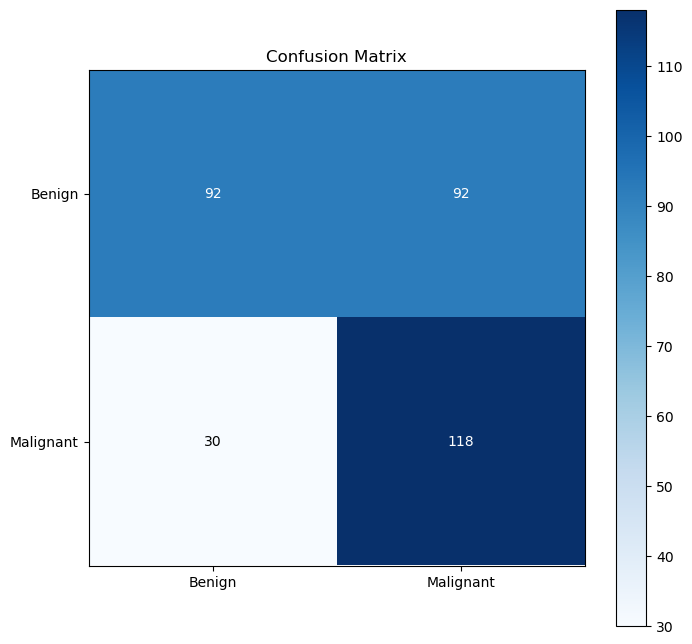

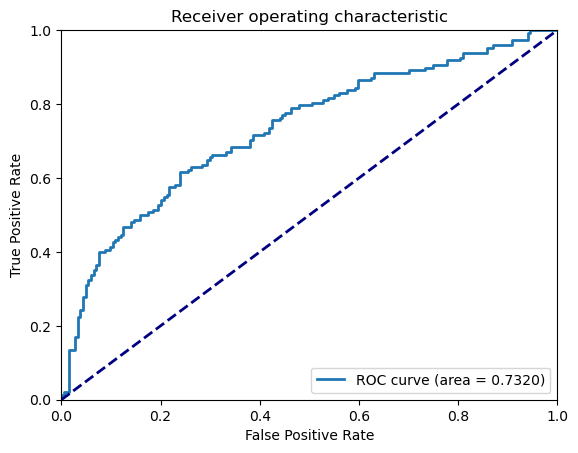

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetv2m',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final/Final',metrics=metric,img_height=img_height,img_width=img_width)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

## FT2

In [ ]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs = 100,
    patience=2,
    Earlystop = 10,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = -1,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'Fine_Tune_2.csv',
    load_weights = weights+'Final/Final',
    save_weights = weights+'Fine_Tune_2/best_model',
    learning_rate=5e-6,init_lr=1e-7,warmup=0,cosine=15,min_lr=1e-8,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final_2/Final_2')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 efficientnetv2-m (Functional)  (None, 7, 7, 1280)   53150388    ['sequential[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnetv2-m[0][0]']   

2023-03-30 15:19:26.873882: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-30 15:19:31.667088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-30 15:19:33.274364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-30 15:19:33.451071: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f43c4003c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-30 15:19:33.451097: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-30 15:19:33.459251: I tensorflow/compiler/mlir/tensorflow

453/453 [==============================] - ETA: 0s - loss: 0.6681 - categorical_accuracy: 0.5900 - precision: 0.5723 - precision_1: 0.6033

2023-03-30 15:20:58.691799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 Epoch 1: accuracy=0.5900, loss=0.6681,  - lr=0.0000050
453/453 [==============================] - 119s 172ms/step - loss: 0.6681 - categorical_accuracy: 0.5900 - precision: 0.5723 - precision_1: 0.6033 - val_loss: 0.5927 - val_categorical_accuracy: 0.6966 - val_precision: 0.6509 - val_precision_1: 0.7545
Epoch 2/2
453/453 [==============================] - 71s 154ms/step - loss: 0.5968 - categorical_accuracy: 0.6711 - precision: 0.6613 - precision_1: 0.6789 - val_loss: 0.5736 - val_categorical_accuracy: 0.7098 - val_precision: 0.6651 - val_precision_1: 0.7647
Epoch 3/3
453/453 [==============================] - 74s 160ms/step - loss: 0.5702 - categorical_accuracy: 0.6998 - precision: 0.6902 - precision_1: 0.7077 - val_loss: 0.5991 - val_categorical_accuracy: 0.7124 - val_precision: 0.6535 - val_precision_1: 0.8013
Epoch 4/4
453/453 [==============================] - 76s 166ms/step - loss: 0.5601 - categorical_accuracy: 0.7130 - precision: 0.6991 - precision_1: 0.7252 - val_loss: 0.547

: 

: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetv2-m (Functional)  (None, 7, 7, 1280)   53150388    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnetv2-m[0][0]']       
 alAveragePooling2D)                                                                              
                                                                                              

2023-03-30 15:45:42.233962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-30 15:45:45.066802: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


 4/83 [>.............................] - ETA: 4s - loss: 0.3034 - categorical_accuracy: 0.8750 - precision: 0.0000e+00 - recall_10: 0.0000e+00 - auc: 0.9531

2023-03-30 15:45:45.330979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


83/83 [==============================] - 6s 49ms/step


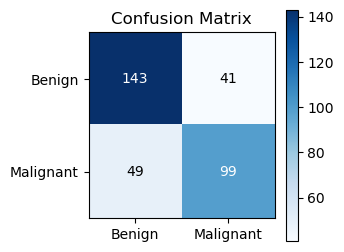

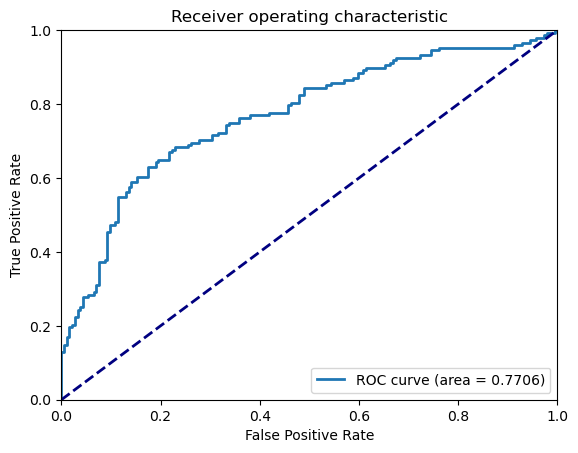

In [ ]:
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetv2m',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

21/21 [==============================] - 3s 133ms/step - loss: 0.6264 - categorical_accuracy: 0.6759 - precision_2: 0.7619 - precision_3: 0.3045